# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$?

In [1]:
# Import everything needed
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import HMProcess, plot_hm_process
from kalman import SteadyStateKalmanFilter
from rnn import NeuralNet
from utils import mk_rand_matrix, mk_rand_matrix_envals

rng = np.random.default_rng()

In [2]:
# Define some arbitrary parameters
def create_process_3d(rng, A=None):
    if A is None:
        A = np.diag([0.98, 0.96, 0.94])
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

proc = create_process_3d(rng)

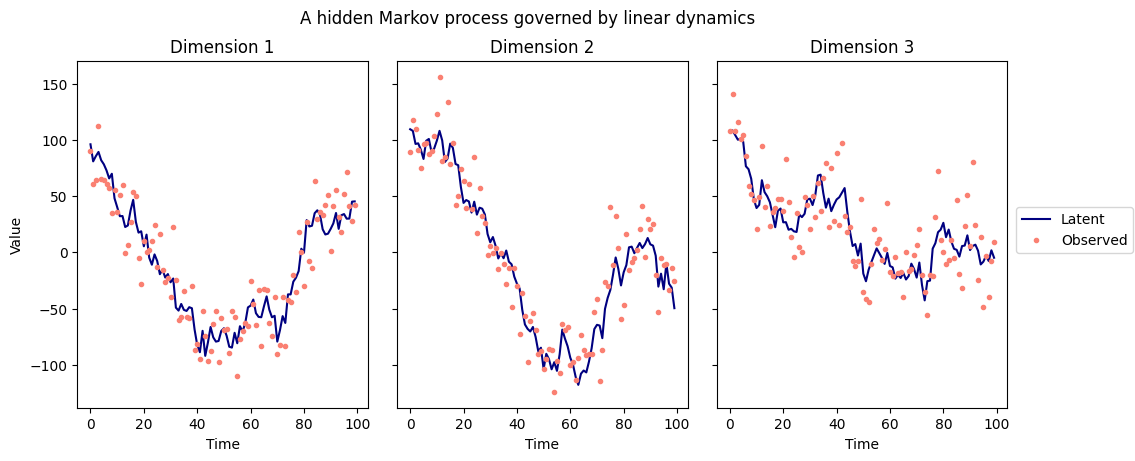

In [3]:
ts, xs, ys = proc.simulate()
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

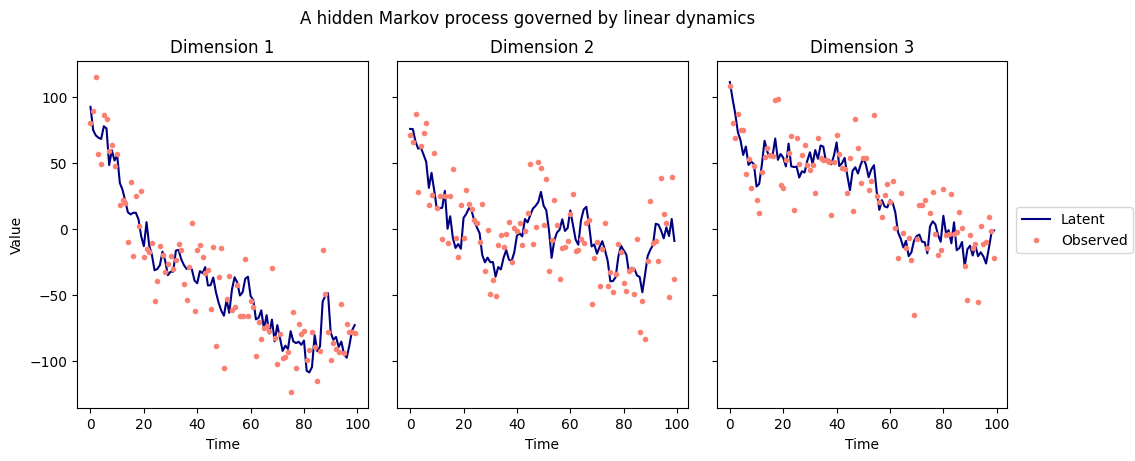

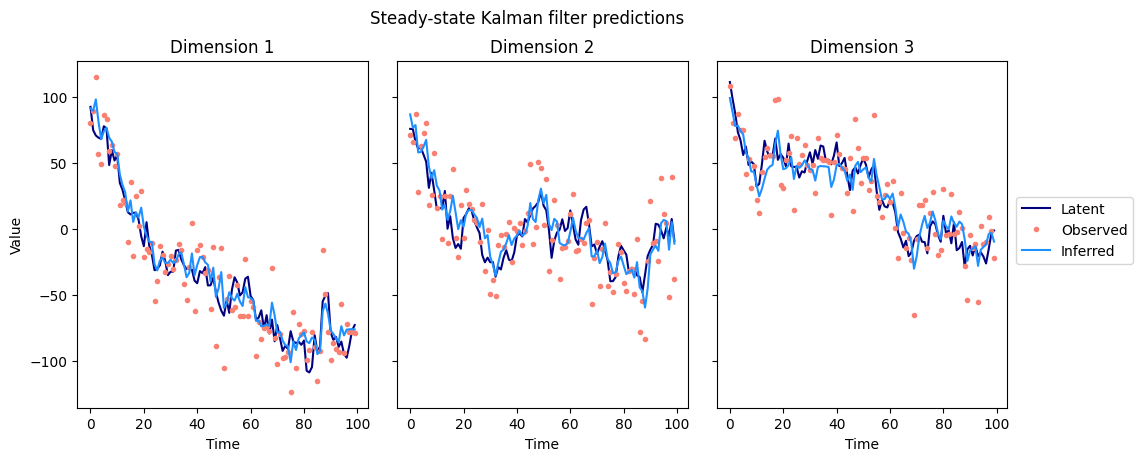

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = proc.simulate()
kf = SteadyStateKalmanFilter(proc)
xhats = kf.infer(ys)

# Now, let's plot it!
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

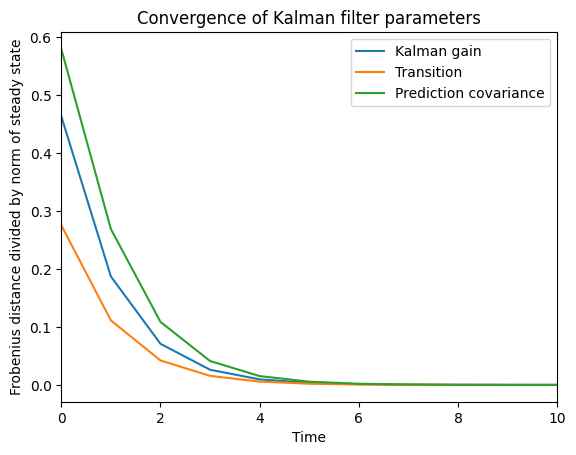

In [5]:
# Let's check how well the Kalman filter converges to the steady-state Kalman filter.
Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
plt.plot(np.arange(proc.num_steps), K_infty_dist/np.linalg.norm(kf.K_infty, ord='fro'), label='Kalman gain')
plt.plot(np.arange(proc.num_steps), M_infty_dist/np.linalg.norm(kf.M_infty, ord='fro'), label='Transition')
plt.plot(np.arange(proc.num_steps), Sigma_infty_dist/np.linalg.norm(kf.Sigma_infty, ord='fro'), label='Prediction covariance')
plt.title('Convergence of Kalman filter parameters')
plt.xlabel('Time')
plt.ylabel('Frobenius distance divided by norm of steady state')
plt.xlim(0,10)
plt.legend()
plt.show()


In [6]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
# First, let's make the matrix A of the hidden Markov process random.
A = mk_rand_matrix_envals(rng, np.array([0.98, 0.96, 0.94]))
proc = create_process_3d(rng, A)
kf = SteadyStateKalmanFilter(proc)

In [7]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    for _ in range(3):
        M = mk_rand_matrix(rng, 3)
        for i in tqdm.tqdm(range(10)):
            c = i/10
            M2 = (1-c)*M + c*kf.M_infty
            nn = NeuralNet(kf.K_infty, M2, np.eye(3), proc.x0)
            Ls = nn.batch_test(100, proc)
            distances.append(np.linalg.norm(M2 - kf.M_infty, ord='fro'))
            losses.append(np.mean(Ls))
    return np.array(distances), np.array(losses)

# distances, losses = test_M_landscape()

In [8]:
# Let's try plotting our results
# plt.scatter(distances[:10], losses[:10])
# plt.scatter(distances[10:20], losses[10:20])
# plt.scatter(distances[20:], losses[20:])
# plt.xlabel('Frobenius distance between M and the optimal value')
# plt.ylabel('Average loss (100 simulated trials)')
# plt.title('Loss vs distance from Kalman filter theory')
# plt.show()

In [19]:
# What happens when we train the neural net on this task?
def compare_nn_kalman(rng, proc, epsilons, batch_size=40):
    print('A =', proc.A)
    print('Eigenvalues = ', np.linalg.eig(proc.A).eigenvalues)
    
    nn = NeuralNet(0.1*mk_rand_matrix(rng, proc.n), 0.1*mk_rand_matrix(rng, proc.n), np.eye(proc.n), proc.x0)
    ts, xs, ys = proc.simulate()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    losses, _, _ = nn.train(epsilons, batch_size, proc)
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Batch')
    plt.ylabel('Mean loss')
    plt.show()
    
    _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    
    # How does it compare to a Kalman filter?
    kf = SteadyStateKalmanFilter(proc)
    xhats = kf.infer(ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', kf.M_infty)
    print('K =', kf.K_infty)

#compare_nn_kalman(rng, proc, np.concatenate((np.full(20, 5e-7), np.full(10, 1e-7))), 40)

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity. Can we plot a loss landscape for the task?

In [10]:
# Let's start with 1 dimension for easy visualization
def create_1d_process(rng, A):
    x0 = np.array([100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.array([[1]])
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 5
num_ticks = 20
a_vals = np.array([-0.95, -0.8, 0, 0.8, 0.95])
num_a_ticks = a_vals.shape[0]
mk_range = 0.99
num_trials_per = 40
W = np.array([[1]])

In [11]:
def find_nn_values_A_M_K_1d(num_nns=2):
    mks = [] # mks[i][j] contains the values of M and K for the jth trial with the ith value of A

    for i, a_ in enumerate(a_vals):
        A = np.array([[a_]])
        mks_i = []
        for j in tqdm.tqdm(range(num_nns)):
            proc = create_1d_process(rng, A)
            nn = NeuralNet(0.1*mk_rand_matrix(rng, 1), 0.1*mk_rand_matrix(rng, 1), np.eye(1), proc.x0)
            _, Ms, Ks = nn.train(np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))), num_trials_per, proc,
                                 print_loss=False, progress_bar=False)
            mks_i.append((Ms.flatten(), Ks.flatten()))
        mks.append(mks_i)

    return mks

# mks = find_nn_values_A_M_K_1d()

100%|█████████████████████████████████████████████████████████| 2/2 [02:02<00:00, 61.33s/it]


In [12]:
def test_A_M_K_loss_landscape_1d():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    W = np.array([[1]])
    
    for i1, a_ in tqdm.tqdm(enumerate(a_vals), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                proc = create_1d_process(rng, A)
                nn = NeuralNet(M, K, W, proc.x0)
                Ls = nn.batch_test(batch_size, proc)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

# losses = test_A_M_K_loss_landscape_1d()

100%|█████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.14s/it]


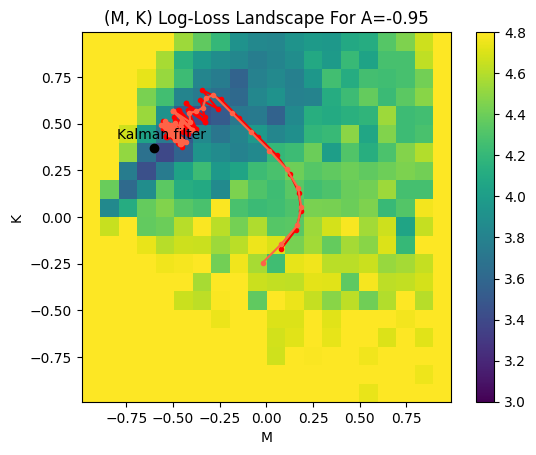

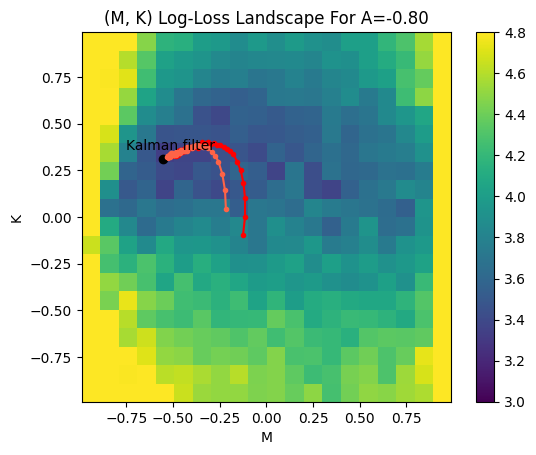

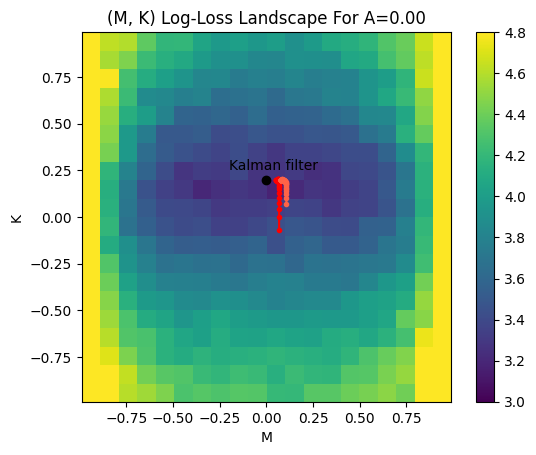

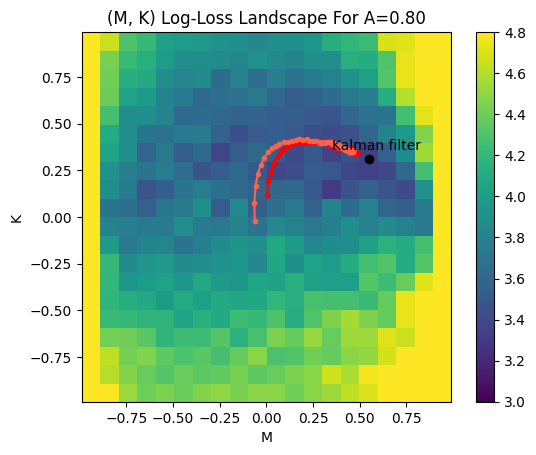

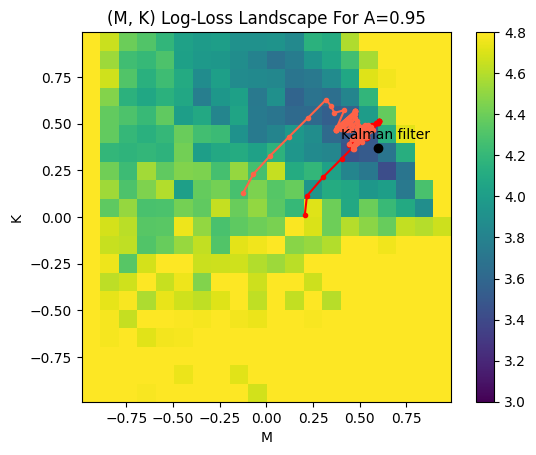

In [13]:
# norm = matplotlib.colors.Normalize(3, 4.8)
# for i1, a_ in enumerate(a_vals):

#    # Loss landscape
#    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#    plt.xlabel('M')
#    plt.ylabel('K')

#    # Where does the Kalman filter fall?
#    A = np.array([[a_]])
#    proc = create_1d_process(rng, A)
#    kf = SteadyStateKalmanFilter(proc)
#    plt.plot(kf.M_infty, kf.K_infty, color='black', marker='o')
#    plt.annotate('Kalman filter', (kf.M_infty, kf.K_infty),
#                 xytext=(kf.M_infty-0.2, kf.K_infty+0.05), color='black')

#    # What about the RNNs?
#    colors = ['red', 'tomato']
#    for j in range(2):
#        plt.plot(mks[i1][j][0], mks[i1][j][1], color=colors[j], linestyle='-', marker='o', markersize=3)
   
#    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
#    plt.xlim(-1*mk_range, mk_range)
#    plt.ylim(-1*mk_range, mk_range)
#    plt.colorbar(c)
#    plt.show()

In [14]:
#def test_mk(proc, m_, k_):
#    A, M, K = proc.A, np.array([[m_]]), np.array([[k_]])
#    nn = NeuralNet(M, K, W, proc.x0)
#    proc = create_1d_process(rng, A)
#    losses = nn.batch_test(100, proc)
#    print(np.mean(losses))

#A = np.array([[a_vals[-1]]])
#proc = create_1d_process(rng, A)
#kf = SteadyStateKalmanFilter(proc)

#m_ = mks[-1][0][0][-1]
#k_ = mks[-1][0][1][-1]
#test_mk(proc, m_, k_)
#test_mk(proc, kf.M_infty, kf.K_infty)

#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.array([[m_]]), np.array([[k_]]), np.eye(1), proc.x0)
#_, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

In [15]:
# # What about two dimensions?
# def create_2d_process(rng, A):
#     x0 = np.array([100, 100])
#     sigma_process = 10
#     Sigma_process = (sigma_process**2)*np.eye(2)
#     O = np.eye(2)
#     sigma_obs = 20
#     Sigma_obs = (sigma_obs**2)*np.eye(2)
#     num_steps = 50
#     return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

# batch_size = 5
# num_a_ticks = 5
# num_ticks = 20
# A = mk_rand_matrix_envals(rng, np.array([0.9, 0.97]))
# proc = create_2d_process(rng, A)
# kf = SteadyStateKalmanFilter(proc)
# mk_range = 0.99
# num_trials_per = 40
# W = np.eye(2)

In [16]:
# def test_K_loss_landscape_2d():
#     M = kf.M_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_k1, k_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_k2, k_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             K = mk_rand_matrix_envals(rng, np.array([k_ev1, k_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_k1,i_k2] = np.mean(Ls)
    
#     return losses

# #losses_K = test_K_loss_landscape_2d()

In [17]:
# def test_M_loss_landscape_2d():
#     K = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M = mk_rand_matrix_envals(rng, 2, np.array([m_ev1, m_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M = test_M_loss_landscape_2d()

In [18]:
# def test_M_loss_landscape_2d_diagentry():
#     K = kf.K_infty
#     M = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M[0,0] = m1
#             M[1,1] = m2
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M_diag = test_M_loss_landscape_2d_diagentry()

In [19]:
# Loss landscape
#norm = matplotlib.colors.Normalize(4, 6)
#c = plt.imshow(np.log10(losses_M_diag.T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#plt.xlabel('M diag 1')
#plt.ylabel('M diag 2')

# Where does the Kalman filter fall?
#envals = (kf.M_infty[0,0], kf.M_infty[1,1])
#plt.plot(envals[0], envals[1], color='black', marker='o')
#plt.annotate('Kalman filter', (envals[0], envals[1]),
#             xytext=(envals[0]-0.2, envals[1]+0.05), color='black')

# What about the RNNs?
#plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')

#plt.title(f'M Log-Loss Landscape')
#plt.xlim(-1*mk_range, mk_range)
#plt.ylim(-1*mk_range, mk_range)
#plt.colorbar(c)
#plt.show()

In [20]:
#kf = SteadyStateKalmanFilter(proc)
#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.diag((0,0.5)), kf.K_infty, np.eye(2), proc.x0)
#_, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

#print(kf.Sigma_infty)

# Exploration 3
The goal of this exploration is to work out some possible bugs with the implementation of the Kalman filter (why does the covariance matrix not converge properly?) and find an appropriate method to systematically determine values of the buy-in period (at what time step do we start the loss calculation?) and input gain.

First bug solved: the issue was that I was plotting the distance between the posterior estimate covariance and the steady-state estimate covariance when I should have been plotting the distance between the prior estimate covariance and the steady-state estimate covariance instead. Now the graph looks as expected.

Let's experiment next with simulating 1D processes and checking how long the buy-in period is.

In [21]:
def create_process_1d_more_parameters(rng, a, sigma_process, sigma_obs):
    A = np.array([[a]])
    x0 = np.array([100])
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.eye(1)
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps, start_from=0)

def time_of_convergence(proc, eps=0.05, i=0):
    kf = SteadyStateKalmanFilter(proc)
    Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
    for i in range(proc.num_steps-1,-1,-1):
        if Sigma_infty_dist[i] > eps:
            return i+1
        if K_infty_dist[i] > eps:
            return i+1
        if M_infty_dist[i] > eps:
            return i+1
    return 0

def plot_1d_kalman_convergence_dynamics():
    num_points = 100
    a_vals = np.linspace(0.01,0.99,num_points)
    t_vals = np.zeros(num_points)
    for i in range(num_points):
        proc = create_process_1d_more_parameters(rng, a_vals[i], 10, 25)
        t_vals[i] = time_of_convergence(proc)
    plt.plot(a_vals, t_vals, label='Actual trend')
    plt.plot(a_vals, -1/np.log(a_vals), label='Proportional to time constant')
    plt.plot(a_vals, 11*a_vals+2, label='Roughly linear')
    plt.title('Length of buy-in period vs largest eigenvalue (1D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.ylim(0,12)
    plt.legend()
    plt.show()

#plot_1d_kalman_convergence_dynamics()

It looks like the fit is not proportional to the time constant of the process, as I would have expected, but instead is roughly linear! Choosing a buy-in time period of eleven times the value of A plus two should be sufficient for letting the Kalman filter converge. What if we try changing the noise parameters?

In [22]:
def plot_1d_kalman_convergence_noise():
    num_points = 30
    max_proc_noise = 50
    max_obs_noise = 50
    sigma_proc_vals = np.linspace(1,max_proc_noise,num_points)
    sigma_obs_vals = np.linspace(1,max_obs_noise,num_points)
    t_vals = np.zeros((num_points,num_points))
    for i in range(num_points):
        for j in range(num_points):
            proc = create_process_1d_more_parameters(rng, 0.99, sigma_proc_vals[i], sigma_obs_vals[j])
            t_vals[i,j] = time_of_convergence(proc)
    norm = matplotlib.colors.Normalize(0, 11)
    plt.imshow(t_vals, extent=(1,max_obs_noise,1,max_proc_noise), origin='lower', norm=norm)
    x_vals = np.linspace(1, max_obs_noise, 200)
    plt.plot(x_vals, x_vals/2, color='red')
    plt.title('Length of buy-in period vs noise (1D)')
    plt.xlabel('Observation noise standard deviation')
    plt.ylabel('Process noise standard deviation')
    plt.xlim(1, max_obs_noise)
    plt.ylim(1, max_proc_noise)
    plt.colorbar()
    plt.show()

#plot_1d_kalman_convergence_noise()

Process and observation noise seem to make the convergence take much longer when the observation noise is high and the process noise is very low. A=0.99 originally took 11 steps, and most of this graph is in the non-yellow region where the number of steps needed is below 11 steps, as long as the observation noise is less than twice the process noise (which is the red line).

Now, let's try it with multi-dimensional processes.

In [23]:
def create_process_3d_based_on_envals(rng, enval1, enval2, enval3):
    A = mk_rand_matrix_envals(rng, np.array([enval1, enval2, enval3]))
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def plot_3d_kalman_convergence_dynamics():
    max_envals = []
    t_vals = []
    num_points = 10
    enval_space = np.linspace(0.01,0.99,num_points)
    for enval1 in enval_space:
        for enval2 in enval_space:
            for enval3 in enval_space:
                try:
                    proc = create_process_3d_based_on_envals(rng, enval1, enval2, enval3)
                    t_vals.append(time_of_convergence(proc))
                    max_envals.append(max(enval1, enval2, enval3))
                except sklearn.exceptions.ConvergenceWarning:
                    pass
    
    plt.scatter(max_envals, t_vals)
    plt.title('Length of buy-in period vs largest eigenvalue (3D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.show()

#plot_3d_kalman_convergence_dynamics()

The graph has roughly the same shape as in the 1D case, which is reassuring, although there are some matrices which are outliers. Let's check one of them by hand. All in all, I conclude that if the process noise is more than half the observation noise, then a buy-in period of a little bit more than 10 times the largest eigenvalue of the dynamics matrix should suffice.

Next, how do we deal with the input gain?

In [24]:
def find_appropriate_gain(proc, M):
    # return best K?
    pass

def plot_gain_function():
    norm = matplotlib.colors.Normalize(3, 4.8)
    for i1, a_ in enumerate(a_vals):
    
        # Loss landscape
        c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
        plt.xlabel('M')
        plt.ylabel('K')
    
        # Best values for K, given M?
        ms = np.linspace(-1*mk_range, mk_range, 100)
        ks = []
        proc = create_1d_process(rng, np.array([[a_]]))
        for m_ in ms:
            K = find_appropriate_gain(proc, np.array([[m_]]))
            ks.append(K[0,0])
        ks = np.array(ks)
        plt.plot(ms, ks, color='red')
        
        plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
        plt.xlim(-1*mk_range, mk_range)
        plt.ylim(-1*mk_range, mk_range)
        plt.colorbar(c)
        plt.show()

#plot_gain_function()

# Exploration 4
Now, what if we add some structure onto our connectivity matrix?

In [14]:
# Let's see if the loss is impacted by a mask

def mk_nd_proc(rng, n, envals=None, A=None):
    if A is None:
        if envals is None:
            envals = np.linspace(0.8, 0.95, n)
        A = mk_rand_matrix_envals(rng, envals)
    x0 = np.full(n, 100)
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(n)
    O = np.eye(n)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(n)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def test_masks(rng, n, masks, etas, envals=None, A=None):
    num_processes = 1
    num_nns = 3
    batch_size = 40
    processes = []
    data = [] # loss indexed by process number, then number of connections, then pattern
    for process_num in range(num_processes):
        data_this_rep = dict()
        proc = mk_nd_proc(rng, n, envals=envals, A=A)
    
        print('Process dynamics:', proc.A)
        print('Eigenvalues:', np.linalg.eig(proc.A).eigenvalues)
        kf = SteadyStateKalmanFilter(proc)
        print('Kalman filter M:', kf.M_infty)
        print('Kalman filter K:', kf.K_infty)
        nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(n), proc.x0)
        Ls = nn.batch_test(batch_size, proc)
        print('Kalman filter loss:', np.mean(Ls))

        max_val_A = np.max(np.abs(proc.A))

        for name, mask in tqdm.tqdm(masks.items()):
            num_connections = np.count_nonzero(mask)
            losses = []
            trial_num = 1
            while True:
                if trial_num > 100:
                    raise FloatingPointError(f'Gradient descent of {num_nns} networks unsuccessful after 100 attempts')
                try:
                    print(f'Testing {name}, Trial {trial_num}')
                    nn = NeuralNet(0.1*max_val_A*mk_rand_matrix(rng, n), 0.1*max_val_A*mk_rand_matrix(rng, n),
                                   np.eye(n), proc.x0, mask=mask)
                    Ls, _, _ = nn.train(etas, batch_size, proc,
                                        print_loss=False, progress_bar=False)
                    losses.append(Ls[-1])
                    print('NN M:', nn.M)
                    print('NN K:', nn.K)
                    if len(losses) >= num_nns:
                        break
                    trial_num += 1
                except FloatingPointError:
                    trial_num += 1
            min_loss = np.min(losses)
            if num_connections in data_this_rep:
                data_this_rep[num_connections][name] = min_loss
            else:
                data_this_rep[num_connections] = {name: min_loss}
        processes.append(proc)
        data.append(data_this_rep)
        
        N = len(data_this_rep)
        fig, axs = plt.subplots(1, N, sharey=True, squeeze=False)
        axs = np.reshape(axs, (N,))
        fig.set_size_inches(12, 4.5)
        for i, (num_connections, d) in enumerate(data_this_rep.items()):
            xticks = np.arange(len(d))
            axs[i].bar(xticks, d.values())
            axs[i].set_xticks(xticks, d.keys(), rotation=90)
            axs[i].set_title(f'Process {process_num},\n{num_connections} connections')
        axs[0].set_ylabel('Loss')
        plt.show()

    return data

In [15]:
masks_one_neuron = {
    'Empty': np.array([[0]]),
    'One loop': np.array([[1]])
}

masks_two_neurons = {
    'Empty': np.array([
        [0, 0],
        [0, 0]
    ]),
    'One loop': np.array([
        [1, 0],
        [0, 0]
    ]),
    'Uni-directional': np.array([
        [0, 1],
        [0, 0]
    ]),
    'Two loops': np.array([
        [1, 0],
        [0, 1]
    ]),
    'Loop pointing outward': np.array([
        [1, 0],
        [1, 0]
    ]),
    'Loop pointing inward': np.array([
        [0, 0],
        [1, 1]
    ]),
    'Bidirectional': np.array([
        [0, 1],
        [1, 0]
    ]),
    'Loop pointing to loop': np.array([
        [1, 0],
        [1, 1]
    ]),
    'Loop with bidirectional': np.array([
        [1, 1],
        [1, 0]
    ]),
    'Full': np.array([
        [1, 1],
        [1, 1]
    ])
}

masks_three_neurons_all_loops = {
    'Empty': np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]),
    'Unidirectional': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Source': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Linear': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [0, 0, 1]
    ]),
    'Bidirectional out': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Transitive triangle': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Bidirectional in': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Cycle': np.array([
        [1, 0, 1],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Bidirectional source': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Two bidirectionals': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional loop': np.array([
        [1, 1, 0],
        [1, 1, 1],
        [1, 0, 1]
    ]),
    'Bidirectional sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [1, 1, 1]
    ]),
    'Full minus one': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Full': np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ])
}

In [ ]:
# test_masks(rng, 1, masks_one_neuron, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
#           envals=np.array([0.95]))

Process dynamics: [[ 0.7686425 -0.121744 ]
 [ 0.0467121  0.9813575]]
Eigenvalues: [0.8  0.95]
Kalman filter M: [[ 0.53550135 -0.06316309]
 [ 0.04579726  0.60582255]]
Kalman filter K: [[ 0.30464638 -0.02190032]
 [-0.02190032  0.37995197]]
Kalman filter loss: 5194.475826729


  0%|                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.52616699 -0.22005009]
 [-0.21855971  0.77192163]]
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.52517361 -0.21543606]
 [-0.21885566  0.77326254]]
Testing Empty, Trial 3


 10%|█████▎                                               | 1/10 [06:54<1:02:14, 414.93s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.52396026 -0.21938745]
 [-0.21485538  0.77556498]]
Testing One loop, Trial 1
NN M: [[0.43554646 0.        ]
 [0.         0.        ]]
NN K: [[ 0.38828508 -0.09542702]
 [-0.21380549  0.77015543]]
Testing One loop, Trial 2
NN M: [[0.37447004 0.        ]
 [0.         0.        ]]
NN K: [[ 0.43000034 -0.10015941]
 [-0.21726454  0.77668088]]
Testing One loop, Trial 3


 20%|███████████                                            | 2/10 [14:25<58:05, 435.63s/it]

NN M: [[0.44021777 0.        ]
 [0.         0.        ]]
NN K: [[ 0.38772811 -0.08867006]
 [-0.21297433  0.77057084]]
Testing Uni-directional, Trial 1
NN M: [[ 0.         -0.23177764]
 [ 0.          0.        ]]
NN K: [[ 0.44471073 -0.07967348]
 [-0.25451027  0.75362898]]
Testing Uni-directional, Trial 2
NN M: [[ 0.         -0.23269271]
 [ 0.          0.        ]]
NN K: [[ 0.44933384 -0.07281438]
 [-0.24937199  0.75230975]]
Testing Uni-directional, Trial 3


 30%|████████████████▌                                      | 3/10 [21:12<49:18, 422.57s/it]

NN M: [[ 0.         -0.23354685]
 [ 0.          0.        ]]
NN K: [[ 0.44194073 -0.0695794 ]
 [-0.25104307  0.75814781]]
Testing Two loops, Trial 1
NN M: [[0.28439367 0.        ]
 [0.         0.27274049]]
NN K: [[ 0.44191136 -0.13792795]
 [-0.11487936  0.61299535]]
Testing Two loops, Trial 2


/home/etao/Desktop/cmu-project/rnn.py:109: RuntimeWarning: overflow encountered in matmul
  rs[i] = self.M @ rs[i-1] + self.K @ ys[i]
/home/etao/Desktop/cmu-project/rnn.py:110: RuntimeWarning: invalid value encountered in matmul
  xhats[i] = self.W @ rs[i]
/home/etao/Desktop/cmu-project/rnn.py:109: RuntimeWarning: invalid value encountered in matmul
  rs[i] = self.M @ rs[i-1] + self.K @ ys[i]


Testing Two loops, Trial 3
Testing Two loops, Trial 4
NN M: [[0.30247017 0.        ]
 [0.         0.33629949]]
NN K: [[ 0.43988622 -0.12936887]
 [-0.08999954  0.57659468]]
Testing Two loops, Trial 5


 40%|██████████████████████                                 | 4/10 [28:08<42:00, 420.13s/it]

NN M: [[0.4345219  0.        ]
 [0.         0.33137922]]
NN K: [[ 0.39092514 -0.08628863]
 [-0.09242745  0.57581944]]
Testing Loop pointing outward, Trial 1
NN M: [[ 0.30315489  0.        ]
 [-0.38584392  0.        ]]
NN K: [[ 0.3905804  -0.17247003]
 [-0.08472587  0.65815664]]
Testing Loop pointing outward, Trial 2
NN M: [[ 0.38168897  0.        ]
 [-0.38832604  0.        ]]
NN K: [[ 0.36176788 -0.13886125]
 [-0.0861855   0.65773794]]
Testing Loop pointing outward, Trial 3


 50%|███████████████████████████▌                           | 5/10 [34:43<34:14, 410.92s/it]

NN M: [[ 0.21578842  0.        ]
 [-0.30007229  0.        ]]
NN K: [[ 0.44597068 -0.1845198 ]
 [-0.12752647  0.6810729 ]]
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [-0.24336974  0.26211856]]
NN K: [[ 0.48854901 -0.24222011]
 [-0.02331639  0.5554525 ]]
Testing Loop pointing inward, Trial 2
NN M: [[ 0.          0.        ]
 [-0.29396532  0.12575628]]
NN K: [[ 0.48623146 -0.24435096]
 [-0.06714017  0.63432416]]
Testing Loop pointing inward, Trial 3
Testing Loop pointing inward, Trial 4


 60%|█████████████████████████████████                      | 6/10 [41:36<27:27, 411.91s/it]

NN M: [[ 0.          0.        ]
 [-0.23746262  0.2508066 ]]
NN K: [[ 0.49794157 -0.23866812]
 [-0.03806748  0.55626187]]
Testing Bidirectional, Trial 1
Testing Bidirectional, Trial 2
Testing Bidirectional, Trial 3
NN M: [[ 0.         -0.24645897]
 [-0.36447868  0.        ]]
NN K: [[ 0.39987882 -0.11065414]
 [-0.13936832  0.64155546]]
Testing Bidirectional, Trial 4
Testing Bidirectional, Trial 5
Testing Bidirectional, Trial 6
Testing Bidirectional, Trial 7
Testing Bidirectional, Trial 8
NN M: [[ 0.         -0.24846377]
 [-0.38202345  0.        ]]
NN K: [[ 0.38882271 -0.10830452]
 [-0.13440135  0.63526436]]
Testing Bidirectional, Trial 9
Testing Bidirectional, Trial 10


 70%|██████████████████████████████████████▌                | 7/10 [49:51<21:56, 438.92s/it]

NN M: [[ 0.         -0.33720862]
 [-0.32141638  0.        ]]
NN K: [[ 0.36787835 -0.04321318]
 [-0.17956473  0.63272054]]
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.42432535  0.        ]
 [-0.08545987  0.35315373]]
NN K: [[ 0.38876154 -0.09420449]
 [-0.03934871  0.53969362]]
Testing Loop pointing to loop, Trial 2
Testing Loop pointing to loop, Trial 3
Testing Loop pointing to loop, Trial 4
NN M: [[ 0.37305484  0.        ]
 [-0.06408897  0.26309525]]
NN K: [[ 0.41218208 -0.10738042]
 [-0.08679574  0.60876096]]
Testing Loop pointing to loop, Trial 5
Testing Loop pointing to loop, Trial 6


 80%|████████████████████████████████████████████           | 8/10 [57:29<14:50, 445.11s/it]

NN M: [[ 0.39729543  0.        ]
 [-0.04823048  0.26393946]]
NN K: [[ 0.40763092 -0.10185323]
 [-0.09721354  0.61480697]]
Testing Loop with bidirectional, Trial 1
NN M: [[-0.01373753 -0.31458772]
 [-0.38855728  0.        ]]
NN K: [[ 0.36193143 -0.08044733]
 [-0.16150152  0.61352489]]
Testing Loop with bidirectional, Trial 2
NN M: [[ 0.03763805 -0.3007751 ]
 [-0.43286971  0.        ]]
NN K: [[ 0.34752989 -0.07604866]
 [-0.13789905  0.59612913]]
Testing Loop with bidirectional, Trial 3
Testing Loop with bidirectional, Trial 4


 90%|███████████████████████████████████████████████▋     | 9/10 [1:04:15<07:12, 432.81s/it]

NN M: [[-0.008825   -0.32918951]
 [-0.4516553   0.        ]]
NN K: [[ 0.33653836 -0.08035081]
 [-0.13785876  0.58691328]]
Testing Full, Trial 1
Testing Full, Trial 2
Testing Full, Trial 3
NN M: [[ 0.21261473 -0.13847687]
 [-0.01670875  0.32862346]]
NN K: [[ 0.4267157  -0.05533531]
 [-0.10522669  0.57127906]]
Testing Full, Trial 4
Testing Full, Trial 5
Testing Full, Trial 6
Testing Full, Trial 7
Testing Full, Trial 8
NN M: [[ 0.22796148 -0.0980851 ]
 [ 0.00617231  0.29116448]]
NN K: [[ 0.44129815 -0.08335374]
 [-0.12319536  0.60954146]]
Testing Full, Trial 9


100%|████████████████████████████████████████████████████| 10/10 [1:12:00<00:00, 432.03s/it]

NN M: [[ 0.26384716 -0.10907489]
 [-0.04387553  0.35945925]]
NN K: [[ 0.42380472 -0.05767963]
 [-0.07661967  0.54064072]]


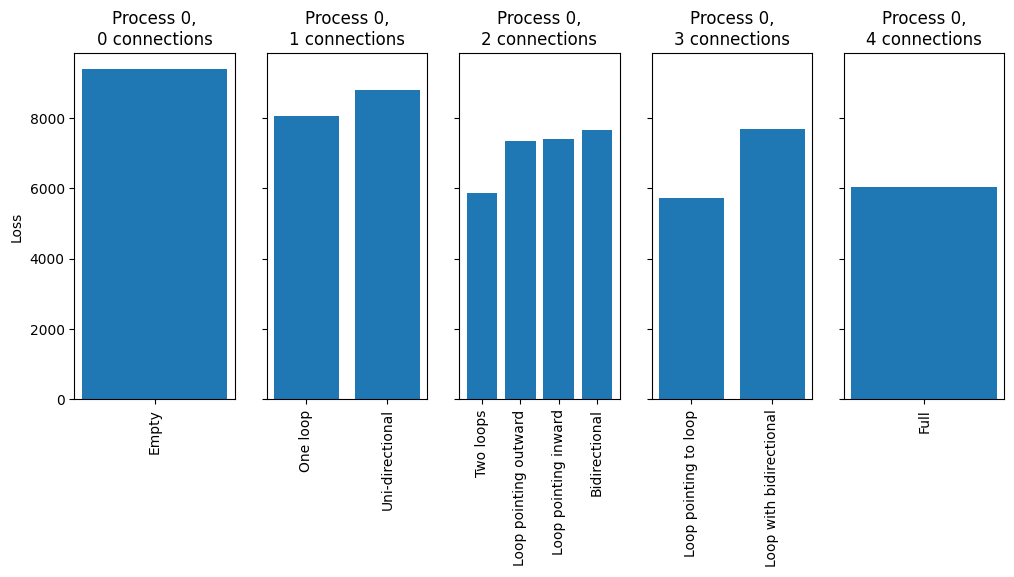

[{0: {'Empty': 9384.325258755154},
  1: {'One loop': 8069.624204289489, 'Uni-directional': 8786.902622894397},
  2: {'Two loops': 5876.090526281641,
   'Loop pointing outward': 7361.999189583558,
   'Loop pointing inward': 7418.882746819946,
   'Bidirectional': 7666.544939133627},
  3: {'Loop pointing to loop': 5723.242435329684,
   'Loop with bidirectional': 7693.612974203333},
  4: {'Full': 6032.261221490941}}]

In [27]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
           envals=np.array([0.8, 0.95]))

#test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
#           envals=np.array([0.95, -0.3]))

#test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(30, 1e-10), np.full(30, 1e-11))),
#           A=np.array([[0.8, 0.8],[-0.8, 0.8]]))

Process dynamics: [[ 0.86146207  0.02668318 -0.37115726]
 [-0.05818443  0.81554867 -0.31619765]
 [-0.0485221  -0.03500411  0.72298926]]
Eigenvalues: [0.6  0.95 0.85]
Kalman filter M: [[ 0.54141288 -0.00446833 -0.18572296]
 [-0.06095382  0.53626166 -0.16808605]
 [ 0.01088081  0.01223532  0.4862911 ]]
Kalman filter K: [[ 0.36995222  0.02368047 -0.05620573]
 [ 0.02368047  0.33978536 -0.04409899]
 [-0.05620573 -0.04409899  0.27924758]]
Kalman filter loss: 7624.02379734457


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.18939144  0.          0.        ]
 [ 0.          0.11645696  0.        ]
 [-0.          0.         -0.17074304]]
NN K: [[ 0.51086006  0.13074065 -0.22233096]
 [ 0.08680599  0.19647135 -0.1765816 ]
 [-0.14493374 -0.07615813  0.05230165]]
Testing Empty, Trial 2
NN M: [[ 0.2126701   0.          0.        ]
 [ 0.          0.04889458  0.        ]
 [ 0.         -0.          0.08136853]]
NN K: [[ 0.52955259  0.06538625 -0.13438875]
 [ 0.11391143  0.23756188 -0.05638485]
 [-0.1392375  -0.07908932  0.07662817]]
Testing Empty, Trial 3


  6%|███▎                                                | 1/16 [16:52<4:13:00, 1012.05s/it]

NN M: [[ 0.06326464  0.          0.        ]
 [ 0.          0.00804111  0.        ]
 [ 0.          0.         -0.11554148]]
NN K: [[ 0.59398594  0.10839019 -0.11808764]
 [ 0.08585472  0.20733143 -0.1159974 ]
 [-0.11685791 -0.06886137  0.07870624]]
Testing Unidirectional, Trial 1
NN M: [[ 0.16011474  0.          0.        ]
 [-0.03680137  0.20889632  0.        ]
 [ 0.          0.         -0.02605557]]
NN K: [[ 0.50243647  0.15338401 -0.26315676]
 [ 0.15444909  0.23239961 -0.05878162]
 [-0.14890841 -0.03701583  0.1127879 ]]
Testing Unidirectional, Trial 2
NN M: [[0.10949966 0.         0.        ]
 [0.0842014  0.02403679 0.        ]
 [0.         0.         0.02522025]]
NN K: [[ 0.56615319  0.17322583 -0.07849703]
 [ 0.1340928   0.11973684 -0.05346993]
 [-0.08431374 -0.06897202  0.14312524]]
Testing Unidirectional, Trial 3


 12%|██████▌                                             | 2/16 [43:14<5:14:29, 1347.82s/it]

NN M: [[ 0.13334721  0.          0.        ]
 [ 0.03179382 -0.12502911  0.        ]
 [ 0.          0.         -0.06846877]]
NN K: [[ 0.52078291  0.18136087 -0.17490804]
 [ 0.13492712  0.130038   -0.12074392]
 [-0.1792154   0.03606355 -0.0031885 ]]
Testing Source, Trial 1
NN M: [[ 0.18271271  0.          0.        ]
 [ 0.00851808  0.0648864   0.        ]
 [-0.06537292  0.         -0.05599396]]
NN K: [[ 0.52156935  0.26193748 -0.00555193]
 [ 0.11358712  0.14425388 -0.07377692]
 [-0.09558667 -0.0869803   0.10878578]]
Testing Source, Trial 2
NN M: [[ 0.26175859  0.          0.        ]
 [ 0.05895891  0.05675964  0.        ]
 [-0.01317037  0.          0.00789064]]
NN K: [[ 0.48623188  0.24152233 -0.11886228]
 [ 0.09649864  0.15259262 -0.02415858]
 [-0.1396     -0.03911111  0.06459002]]
Testing Source, Trial 3


 19%|█████████▍                                        | 3/16 [1:11:28<5:26:13, 1505.63s/it]

NN M: [[ 0.24473516  0.         -0.        ]
 [ 0.03529761  0.20557158  0.        ]
 [-0.0268845   0.          0.08091164]]
NN K: [[ 0.55011517  0.10592877 -0.14041699]
 [ 0.09016881  0.22978323 -0.10067626]
 [-0.15037508 -0.11185941  0.04004913]]
Testing Bidirectional, Trial 1
NN M: [[ 0.22691685  0.10364017  0.        ]
 [ 0.01756215 -0.09324715  0.        ]
 [ 0.         -0.          0.04810519]]
NN K: [[ 0.51201972  0.16896122 -0.15138753]
 [ 0.24207572  0.16775274  0.06580788]
 [-0.07272767 -0.12463548  0.18121397]]
Testing Bidirectional, Trial 2
NN M: [[ 0.21166198 -0.07729413  0.        ]
 [ 0.12094324 -0.12099264  0.        ]
 [-0.          0.         -0.01381355]]
NN K: [[ 0.51899055  0.17957469 -0.19839161]
 [ 0.07068728  0.11177812 -0.09389027]
 [-0.13047779 -0.03630646  0.08140651]]
Testing Bidirectional, Trial 3


 25%|████████████▌                                     | 4/16 [1:36:32<5:01:01, 1505.12s/it]

NN M: [[0.33540297 0.02053525 0.        ]
 [0.01898686 0.20938372 0.        ]
 [0.         0.         0.05662721]]
NN K: [[ 0.56460927  0.07602434 -0.03216958]
 [ 0.14316274  0.15174576 -0.01582879]
 [-0.1798474  -0.0880921   0.02127224]]
Testing Linear, Trial 1
NN M: [[ 0.15735687  0.         -0.        ]
 [-0.02078998 -0.21997138 -0.        ]
 [ 0.         -0.01678182 -0.05661524]]
NN K: [[ 0.52432894  0.16020157 -0.12382729]
 [ 0.08227268  0.25294723 -0.05933199]
 [-0.15287738 -0.10963265  0.06064175]]
Testing Linear, Trial 2
NN M: [[ 0.12093208  0.         -0.        ]
 [ 0.0387169  -0.02271938  0.        ]
 [-0.         -0.01223496  0.06525159]]
NN K: [[ 0.56269006  0.12298863 -0.11886335]
 [ 0.11967134  0.17153987 -0.14424993]
 [-0.16927722  0.01337791  0.14534044]]
Testing Linear, Trial 3


 31%|███████████████▋                                  | 5/16 [2:01:51<4:36:50, 1510.00s/it]

NN M: [[ 0.12189867  0.          0.        ]
 [ 0.00894515  0.11548831  0.        ]
 [ 0.         -0.09216546 -0.13295111]]
NN K: [[ 0.59698043  0.14694959 -0.02897148]
 [ 0.15804059  0.25653862  0.03206277]
 [-0.10093838 -0.07179109  0.11706497]]
Testing Sink, Trial 1
NN M: [[ 0.08600997  0.          0.        ]
 [ 0.15046853 -0.00211135 -0.00110992]
 [ 0.          0.         -0.06838487]]
NN K: [[ 0.62470785  0.09342854 -0.0802875 ]
 [ 0.0475098   0.21101165 -0.00303974]
 [-0.1965213  -0.01486979  0.03698326]]
Testing Sink, Trial 2
NN M: [[ 0.11505562  0.          0.        ]
 [ 0.04855735 -0.0302892  -0.18208452]
 [ 0.         -0.         -0.01840539]]
NN K: [[ 0.54330323  0.17522028 -0.12927669]
 [ 0.14173254  0.18465362 -0.01739241]
 [-0.04226971 -0.19954643  0.17982536]]
Testing Sink, Trial 3


 38%|██████████████████▊                               | 6/16 [2:24:03<4:01:35, 1449.59s/it]

NN M: [[ 0.12448783  0.          0.        ]
 [ 0.03065516  0.07477359  0.02361272]
 [-0.         -0.          0.05617218]]
NN K: [[ 0.53815953  0.08490441 -0.23456513]
 [ 0.1253178   0.21542825 -0.09040279]
 [-0.13539941  0.04764705  0.22368846]]
Testing Bidirectional out, Trial 1
NN M: [[ 0.14711658  0.15856993  0.        ]
 [ 0.0470141   0.07276217  0.        ]
 [-0.07645132  0.          0.05646027]]
NN K: [[ 0.53415955  0.12025264 -0.04763924]
 [ 0.14402325  0.20340689 -0.06729402]
 [-0.09070107 -0.11352613  0.12163211]]
Testing Bidirectional out, Trial 2
NN M: [[ 0.12085405 -0.14160162  0.        ]
 [ 0.06034789 -0.10963224  0.        ]
 [-0.08681823  0.          0.167594  ]]
NN K: [[ 0.58500166  0.08076902 -0.1583932 ]
 [ 0.01602994  0.35329255  0.08442815]
 [-0.09564614 -0.01286667  0.16753641]]
Testing Bidirectional out, Trial 3


 44%|█████████████████████▉                            | 7/16 [2:40:26<3:14:32, 1296.92s/it]

NN M: [[ 0.12384374  0.18290608  0.        ]
 [-0.00502351  0.07480338  0.        ]
 [-0.04560701  0.         -0.04953197]]
NN K: [[ 0.5069103   0.16188853 -0.10416929]
 [ 0.1947067   0.17499922 -0.14407184]
 [-0.1576226   0.00628932 -0.01274482]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.26801024  0.          0.        ]
 [ 0.03797283 -0.06168861  0.        ]
 [-0.10167804  0.0234787  -0.05130128]]
NN K: [[ 0.52636268  0.1262025  -0.15003549]
 [ 0.08242131  0.30610495 -0.11574182]
 [-0.11631432 -0.01613682  0.08400639]]
Testing Transitive triangle, Trial 2
NN M: [[ 0.17573937  0.          0.        ]
 [-0.0404095   0.03031904  0.        ]
 [ 0.02917459 -0.01273688 -0.02281235]]
NN K: [[ 0.56199623  0.0202786  -0.13703388]
 [ 0.13683967  0.20926078 -0.03845187]
 [-0.13720903 -0.07136649  0.10748982]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████                         | 8/16 [2:55:56<2:37:20, 1180.07s/it]

NN M: [[ 0.31876797  0.          0.        ]
 [-0.00498684  0.03859987  0.        ]
 [-0.04943348  0.03017451  0.04489064]]
NN K: [[ 0.51572533  0.12059105 -0.15583378]
 [ 0.14229845  0.16685529 -0.12249629]
 [-0.12207507 -0.06779416  0.13342862]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.2029947  -0.03312545 -0.11806394]
 [ 0.06202557  0.19267704 -0.        ]
 [ 0.          0.         -0.07221361]]
NN K: [[ 0.52151107  0.15654378 -0.05873356]
 [ 0.07339294  0.21279021 -0.05460648]
 [-0.13125673 -0.12823234  0.14432249]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.1577495   0.02001709 -0.01116179]
 [ 0.02748986 -0.03624544  0.        ]
 [ 0.          0.          0.07241768]]
NN K: [[ 0.56644403  0.07413455 -0.15889733]
 [ 0.14819757  0.15983656 -0.0160618 ]
 [-0.15160775 -0.04251144  0.0369222 ]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▏                     | 9/16 [3:10:47<2:07:09, 1089.92s/it]

NN M: [[ 0.19801361 -0.15728373 -0.08851805]
 [ 0.09770904 -0.03898993  0.        ]
 [-0.          0.          0.02846267]]
NN K: [[ 0.56936867  0.14373894 -0.1182796 ]
 [ 0.04068146  0.21348254 -0.02706933]
 [-0.19547508 -0.01449353  0.11368465]]
Testing Cycle, Trial 1
NN M: [[ 0.25572658  0.         -0.15406221]
 [-0.06411929  0.00294927  0.        ]
 [ 0.          0.07952129  0.03483445]]
NN K: [[ 0.48290432  0.07961917 -0.20783908]
 [ 0.14664505  0.24335191  0.00459833]
 [-0.1763238  -0.14857859  0.09252008]]
Testing Cycle, Trial 2
NN M: [[ 0.39826724  0.         -0.00270604]
 [-0.01741906  0.02664814  0.        ]
 [ 0.          0.09732725 -0.05110395]]
NN K: [[ 0.50396975  0.07498882 -0.11229584]
 [ 0.16537725  0.1994233  -0.05638804]
 [-0.1096287  -0.05515867  0.18492069]]
Testing Cycle, Trial 3


 62%|██████████████████████████████▋                  | 10/16 [3:25:39<1:42:51, 1028.66s/it]

NN M: [[ 0.3110177   0.          0.02966142]
 [ 0.00737208  0.05365552  0.        ]
 [-0.          0.19711563 -0.05314599]]
NN K: [[ 0.54205237  0.05139504 -0.17338861]
 [ 0.10315099  0.18439281 -0.06837638]
 [-0.12465601 -0.09970909  0.08422886]]
Testing Bidirectional source, Trial 1
NN M: [[ 0.29837412  0.14484252  0.        ]
 [ 0.1025676   0.07257912  0.        ]
 [-0.05716142 -0.14968008 -0.02741895]]
NN K: [[ 0.47116051  0.09511602 -0.20549587]
 [ 0.10955322  0.23944393 -0.06566338]
 [-0.11744332  0.04095077  0.12087113]]
Testing Bidirectional source, Trial 2
NN M: [[ 0.19460243  0.02057059  0.        ]
 [ 0.01813513  0.09928664  0.        ]
 [-0.07406123 -0.03073566  0.15507554]]
NN K: [[ 0.49853054  0.19533091 -0.18797966]
 [ 0.08430642  0.30286951 -0.09611435]
 [-0.14135416  0.00910944  0.02389195]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [3:40:31<1:22:14, 986.84s/it]

NN M: [[ 0.16003749  0.07193671  0.        ]
 [-0.09212224  0.22294277  0.        ]
 [-0.09629816  0.13176369 -0.01353085]]
NN K: [[ 0.55465978  0.11076021 -0.15123865]
 [ 0.16641004  0.21338793 -0.05810901]
 [-0.09191293 -0.01084391  0.11634054]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.26630636  0.29256423  0.08603897]
 [ 0.01915401 -0.02948657  0.        ]
 [-0.16392077  0.         -0.05900803]]
NN K: [[ 0.52157547  0.11636335 -0.0222064 ]
 [ 0.14848725  0.21901311 -0.17675941]
 [-0.04746675 -0.01315131  0.08168054]]
Testing Two bidirectionals, Trial 2
NN M: [[ 0.2069396   0.11789366  0.21590743]
 [ 0.06444283 -0.0561329   0.        ]
 [-0.04650065  0.          0.02929221]]
NN K: [[ 0.5515242   0.11127567 -0.15570285]
 [ 0.15700023  0.18665504 -0.12280754]
 [-0.02344102 -0.10380499  0.15415338]]
Testing Two bidirectionals, Trial 3


 75%|█████████████████████████████████████▌            | 12/16 [3:55:25<1:03:54, 958.60s/it]

NN M: [[ 0.16119715  0.13747672 -0.03517103]
 [-0.02364543  0.16569134  0.        ]
 [-0.063392    0.         -0.00054331]]
NN K: [[ 0.55421989  0.13267077 -0.07912021]
 [ 0.1949362   0.17847052 -0.03851605]
 [-0.09250343 -0.05594371  0.14276047]]
Testing Bidirectional loop, Trial 1
NN M: [[ 0.16934339 -0.01293755 -0.        ]
 [-0.0286391  -0.15144865  0.04521509]
 [-0.17477846  0.         -0.02853647]]
NN K: [[ 0.53902961  0.04886043 -0.20858939]
 [ 0.11983321  0.17992651  0.00882529]
 [-0.10408951 -0.04253923  0.0682027 ]]
Testing Bidirectional loop, Trial 2
NN M: [[ 0.18584359  0.12648078  0.        ]
 [ 0.06717027  0.06058111 -0.02080278]
 [-0.02406116  0.          0.12470089]]
NN K: [[ 0.51003057  0.12932417 -0.13529786]
 [ 0.12773793  0.2402893  -0.06074055]
 [-0.09648963 -0.1362237   0.13022969]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [4:10:17<46:55, 938.58s/it]

NN M: [[ 0.22134498 -0.22350288  0.        ]
 [ 0.16721818 -0.14905092  0.1018627 ]
 [ 0.0126186   0.          0.05996486]]
NN K: [[ 0.52912287  0.11812052 -0.19303837]
 [-0.05764031  0.15140341 -0.04190009]
 [-0.15873252 -0.04971747  0.01521376]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.05437116  0.          0.        ]
 [ 0.19553103  0.02624135  0.07171533]
 [-0.13773154  0.02857085 -0.03629319]]
NN K: [[ 0.57458315  0.1249017  -0.19142061]
 [ 0.06678575  0.21570256 -0.01649893]
 [-0.11225266  0.01740853  0.10220996]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.12087986  0.          0.        ]
 [ 0.09882319  0.0559517  -0.02747543]
 [-0.042525   -0.00926666 -0.0491513 ]]
NN K: [[ 0.49420146  0.11032273 -0.20702264]
 [ 0.08286043  0.19752201 -0.1123827 ]
 [-0.22620301  0.04804108 -0.02472143]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [4:25:12<30:50, 925.30s/it]

NN M: [[ 0.10284021  0.         -0.        ]
 [ 0.06624142 -0.13464577 -0.04490285]
 [ 0.01329507  0.04274026  0.01147125]]
NN K: [[ 0.49429097  0.1235867  -0.10483375]
 [ 0.10420997  0.20541458 -0.08578491]
 [-0.14951992 -0.11313948  0.08309988]]
Testing Full minus one, Trial 1
NN M: [[ 0.23902076 -0.07450337 -0.06017209]
 [ 0.08796012  0.13831419  0.        ]
 [-0.00179277  0.04028491  0.01985836]]
NN K: [[ 0.56766734  0.15923071 -0.08654282]
 [ 0.05293888  0.25363765 -0.03535594]
 [-0.12745987 -0.11426231  0.16901101]]
Testing Full minus one, Trial 2
NN M: [[ 0.20543458  0.10084017 -0.14118836]
 [ 0.0306184   0.03065636 -0.        ]
 [ 0.05025899 -0.14310846  0.03458107]]
NN K: [[ 0.45483003  0.21385838 -0.17101842]
 [ 0.17622953  0.31036212 -0.07206509]
 [-0.14001053 -0.12228635  0.14030994]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [4:40:04<15:15, 915.15s/it]

NN M: [[ 2.28568994e-01 -2.05721232e-04 -8.61242966e-02]
 [ 6.70315373e-02  6.05957746e-02  0.00000000e+00]
 [-4.04737167e-02 -2.77620379e-02  1.44399695e-01]]
NN K: [[ 0.57129152  0.09694792 -0.09416828]
 [ 0.07701185  0.17929369 -0.06894784]
 [-0.16484884  0.07211369  0.16250666]]
Testing Full, Trial 1
NN M: [[ 0.09904934  0.10305009 -0.09111095]
 [ 0.1214717   0.26419326 -0.00753935]
 [-0.00190374 -0.00716624  0.16728438]]
NN K: [[ 0.51809131  0.12271254 -0.1058757 ]
 [ 0.08755697  0.20380338 -0.04695904]
 [-0.15271264 -0.04261524  0.13103121]]
Testing Full, Trial 2
NN M: [[ 0.24896143 -0.13480109 -0.12695416]
 [ 0.1791952   0.19664249  0.00644481]
 [-0.0559274  -0.00609555 -0.11655942]]
NN K: [[ 0.4795945   0.18097798 -0.23959976]
 [ 0.01668171  0.18208073  0.00820091]
 [-0.12902114 -0.11617835  0.13963061]]
Testing Full, Trial 3


100%|███████████████████████████████████████████████████| 16/16 [4:54:56<00:00, 1106.06s/it]

NN M: [[ 0.34987546  0.11423673 -0.03151669]
 [-0.05867516 -0.02367552 -0.08090676]
 [-0.07054095  0.08539421 -0.06638035]]
NN K: [[ 0.52673479  0.06290216 -0.0604183 ]
 [ 0.14646948  0.18498854 -0.11805775]
 [-0.136491   -0.10373441  0.08143872]]


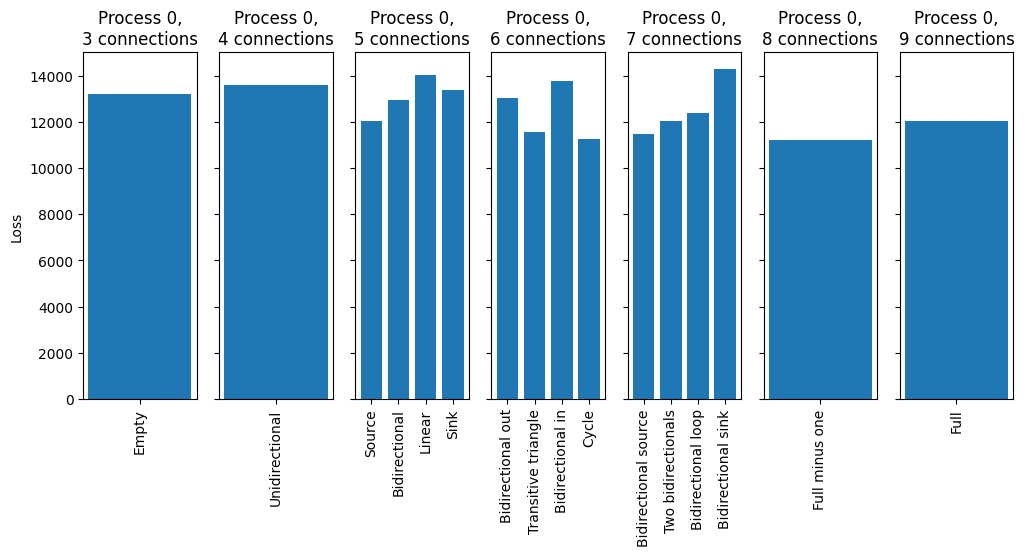

[{3: {'Empty': 13190.999260498887},
  4: {'Unidirectional': 13593.429910020746},
  5: {'Source': 12030.523374165681,
   'Bidirectional': 12934.426475415015,
   'Linear': 14017.281626400976,
   'Sink': 13391.186706276305},
  6: {'Bidirectional out': 13029.162462023825,
   'Transitive triangle': 11558.381847775658,
   'Bidirectional in': 13769.783533965465,
   'Cycle': 11277.478749758688},
  7: {'Bidirectional source': 11464.375782540565,
   'Two bidirectionals': 12045.17229363214,
   'Bidirectional loop': 12376.355800868538,
   'Bidirectional sink': 14292.357440804315},
  8: {'Full minus one': 11201.278333967808},
  9: {'Full': 12044.349541091618}}]

In [30]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(20, 5e-7), np.full(20, 1e-7), np.full(20, 5e-8), np.full(20, 1e-8))),
          envals=np.array([0.6, 0.85, 0.95]))

Process dynamics: [[0.   0.95]
 [0.8  0.  ]]
Eigenvalues: [ 0.87177979 -0.87177979]
Kalman filter M: [[0.         0.61670586]
 [0.54254392 0.        ]]
Kalman filter K: [[0.35083594 0.        ]
 [0.         0.3218201 ]]
Kalman filter loss: 5148.47713876668


  0%|                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.54702662 0.01314452]
 [0.01941884 0.50876147]]
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.54810786 0.01412261]
 [0.01244173 0.50839599]]
Testing Empty, Trial 3


 10%|█████▌                                                 | 1/10 [05:27<49:11, 327.92s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.55115756 0.0183818 ]
 [0.02190652 0.51158448]]
Testing One loop, Trial 1
NN M: [[0.04604089 0.        ]
 [0.         0.        ]]
NN K: [[0.54807289 0.01301557]
 [0.01824483 0.5085334 ]]
Testing One loop, Trial 2
NN M: [[0.09177022 0.        ]
 [0.         0.        ]]
NN K: [[0.54036493 0.01697106]
 [0.02296736 0.50513492]]
Testing One loop, Trial 3


 20%|███████████                                            | 2/10 [10:54<43:36, 327.09s/it]

NN M: [[0.05822289 0.        ]
 [0.         0.        ]]
NN K: [[0.54138362 0.01240759]
 [0.01182856 0.50332865]]
Testing Uni-directional, Trial 1
NN M: [[0.         0.49280602]
 [0.         0.        ]]
NN K: [[0.43184395 0.00759772]
 [0.01487306 0.51932263]]
Testing Uni-directional, Trial 2
NN M: [[0.         0.47808065]
 [0.         0.        ]]
NN K: [[0.43702284 0.00493154]
 [0.01792369 0.52620867]]
Testing Uni-directional, Trial 3


 30%|████████████████▌                                      | 3/10 [16:22<38:13, 327.64s/it]

NN M: [[0.         0.50807437]
 [0.         0.        ]]
NN K: [[0.42903167 0.00883461]
 [0.01685461 0.51890812]]
Testing Two loops, Trial 1
NN M: [[-0.01435793  0.        ]
 [ 0.         -0.00666585]]
NN K: [[0.54523523 0.02188164]
 [0.01835449 0.50856027]]
Testing Two loops, Trial 2
NN M: [[ 0.02022306  0.        ]
 [ 0.         -0.05256164]]
NN K: [[0.5488383  0.01357278]
 [0.0174301  0.50837093]]
Testing Two loops, Trial 3


 40%|██████████████████████                                 | 4/10 [21:49<32:44, 327.48s/it]

NN M: [[0.08785238 0.        ]
 [0.         0.05451357]]
NN K: [[0.53958531 0.01329885]
 [0.01733788 0.50583359]]
Testing Loop pointing outward, Trial 1
NN M: [[0.13726068 0.        ]
 [0.47784963 0.        ]]
NN K: [[ 0.5373563   0.01415116]
 [-0.00893095  0.37978337]]
Testing Loop pointing outward, Trial 2
NN M: [[0.09475058 0.        ]
 [0.46168111 0.        ]]
NN K: [[ 0.548979    0.00580144]
 [-0.0048382   0.38599908]]
Testing Loop pointing outward, Trial 3


 50%|███████████████████████████▌                           | 5/10 [27:18<27:19, 327.89s/it]

NN M: [[0.1499213  0.        ]
 [0.47575168 0.        ]]
NN K: [[ 0.53374197  0.0111235 ]
 [-0.01037729  0.38363304]]
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [ 0.45172857 -0.0253336 ]]
NN K: [[0.55378686 0.02054413]
 [0.0133608  0.38735934]]
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.46158598 0.07531869]]
NN K: [[ 0.55060539  0.00765296]
 [-0.01256159  0.38265487]]
Testing Loop pointing inward, Trial 3


 60%|█████████████████████████████████                      | 6/10 [32:47<21:52, 328.23s/it]

NN M: [[0.         0.        ]
 [0.45582081 0.05271585]]
NN K: [[ 0.5592856   0.00233061]
 [-0.00985872  0.38763292]]
Testing Bidirectional, Trial 1
NN M: [[0.         0.58154546]
 [0.53987997 0.        ]]
NN K: [[ 0.36469939  0.00543455]
 [-0.00063775  0.33519942]]
Testing Bidirectional, Trial 2
NN M: [[0.         0.57183452]
 [0.53569549 0.        ]]
NN K: [[0.36867232 0.00330769]
 [0.00062217 0.33576885]]
Testing Bidirectional, Trial 3


 70%|██████████████████████████████████████▌                | 7/10 [38:15<16:24, 328.33s/it]

NN M: [[0.         0.58642381]
 [0.53548319 0.        ]]
NN K: [[0.36216301 0.00820165]
 [0.00318833 0.33264043]]
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.09451254  0.        ]
 [ 0.47069638 -0.02155363]]
NN K: [[0.54567596 0.01600451]
 [0.0019471  0.38324128]]
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.155896    0.        ]
 [ 0.48418587 -0.07683343]]
NN K: [[0.52992621 0.02713847]
 [0.01068814 0.37794799]]
Testing Loop pointing to loop, Trial 3


 80%|████████████████████████████████████████████           | 8/10 [43:45<10:57, 328.58s/it]

NN M: [[0.05137518 0.        ]
 [0.47503806 0.02341042]]
NN K: [[ 0.55387205  0.01205688]
 [-0.00701597  0.3818674 ]]
Testing Loop with bidirectional, Trial 1
NN M: [[0.00513657 0.58000907]
 [0.537052   0.        ]]
NN K: [[ 3.64179115e-01 -2.51797018e-04]
 [-2.01666401e-03  3.34898544e-01]]
Testing Loop with bidirectional, Trial 2
NN M: [[-5.63287056e-04  5.85131836e-01]
 [ 5.35931099e-01  0.00000000e+00]]
NN K: [[0.36523888 0.00248291]
 [0.00365664 0.3335172 ]]
Testing Loop with bidirectional, Trial 3


 90%|█████████████████████████████████████████████████▌     | 9/10 [49:12<05:28, 328.32s/it]

NN M: [[0.03039707 0.57969046]
 [0.5331326  0.        ]]
NN K: [[ 0.36813449 -0.00583498]
 [-0.01008543  0.33593606]]
Testing Full, Trial 1
NN M: [[-0.01930322  0.59218275]
 [ 0.53111458  0.03423486]]
NN K: [[ 0.36620757 -0.00528389]
 [-0.00463496  0.33134936]]
Testing Full, Trial 2
NN M: [[ 0.00475027  0.57375083]
 [ 0.54830867 -0.02602907]]
NN K: [[0.3658018  0.00715808]
 [0.00620989 0.33671611]]
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████| 10/10 [54:41<00:00, 328.13s/it]

NN M: [[0.01761164 0.57087635]
 [0.53727905 0.01947292]]
NN K: [[ 0.36980195 -0.01320695]
 [-0.01363754  0.33525857]]


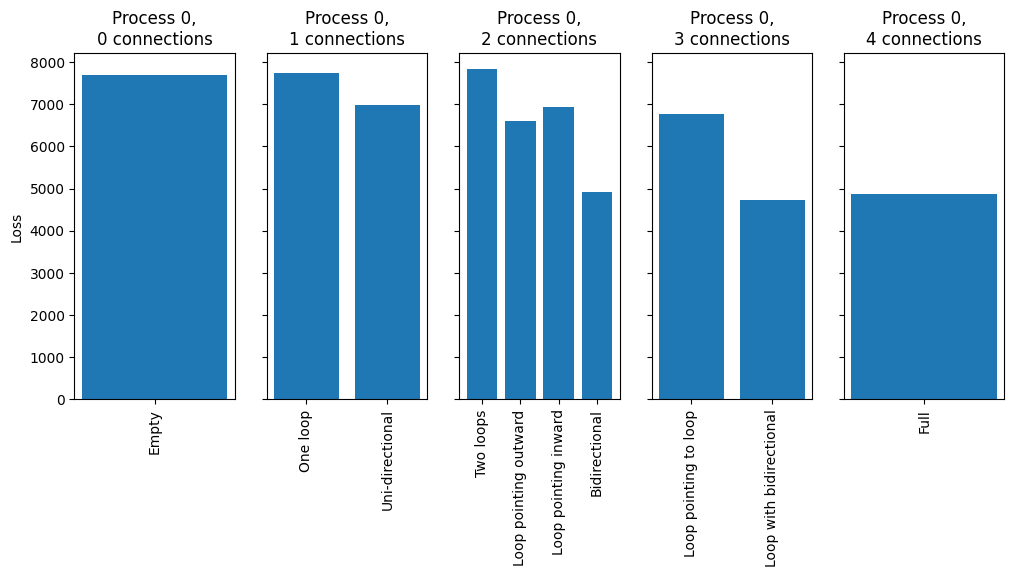

[{0: {'Empty': 7700.9315046873035},
  1: {'One loop': 7728.396291836787, 'Uni-directional': 6988.378738754659},
  2: {'Two loops': 7824.765498116374,
   'Loop pointing outward': 6605.610862848986,
   'Loop pointing inward': 6927.683727289121,
   'Bidirectional': 4925.402983248304},
  3: {'Loop pointing to loop': 6765.550589980807,
   'Loop with bidirectional': 4724.368991875376},
  4: {'Full': 4860.373770817832}}]

In [32]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
           A=np.array([[0, 0.95], [0.8, 0]]))

Process dynamics: [[ 0.6  0.8]
 [-0.8  0.6]]
Eigenvalues: [0.6+0.8j 0.6-0.8j]
Kalman filter M: [[ 0.36576708  0.48768944]
 [-0.48768944  0.36576708]]
Kalman filter K: [[ 3.90388203e-01 -7.85824477e-18]
 [ 1.17873672e-17  3.90388203e-01]]
Kalman filter loss: 5411.843644805048


  0%|                                                                | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 9.73975639e-01 -8.41945477e-04]
 [ 1.27842301e-03  9.68561710e-01]]
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 9.71632792e-01 -4.76048601e-04]
 [ 5.58000446e-04  9.68226586e-01]]
Testing Empty, Trial 3


 10%|█████▎                                               | 1/10 [09:56<1:29:30, 596.73s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 9.69282670e-01  1.23536134e-04]
 [-3.81373538e-04  9.72607224e-01]]
Testing One loop, Trial 1
NN M: [[0.3714043 0.       ]
 [0.        0.       ]]
NN K: [[ 7.55680548e-01  2.88001948e-01]
 [-8.84869741e-04  9.70473434e-01]]
Testing One loop, Trial 2
NN M: [[ 0.42566547  0.        ]
 [-0.          0.        ]]
NN K: [[0.72625049 0.33319355]
 [0.0014045  0.97036405]]
Testing One loop, Trial 3


 20%|██████████▌                                          | 2/10 [20:03<1:20:19, 602.45s/it]

NN M: [[0.3939877 0.       ]
 [0.        0.       ]]
NN K: [[ 0.7433616   0.30898254]
 [-0.00166027  0.96881058]]
Testing Uni-directional, Trial 1
NN M: [[0.         0.38300584]
 [0.         0.        ]]
NN K: [[ 0.6817894  -0.21188013]
 [ 0.00351461  0.96611925]]
Testing Uni-directional, Trial 2
NN M: [[0.         0.43542696]
 [0.         0.        ]]
NN K: [[ 0.64402053 -0.24327246]
 [ 0.00588676  0.97334828]]
Testing Uni-directional, Trial 3


 30%|███████████████▉                                     | 3/10 [31:53<1:16:00, 651.48s/it]

NN M: [[0.         0.39814142]
 [0.         0.        ]]
NN K: [[ 0.66910796 -0.22071563]
 [ 0.00415773  0.96844107]]
Testing Two loops, Trial 1
NN M: [[0.28289584 0.        ]
 [0.         0.41759289]]
NN K: [[ 0.81413771  0.21938791]
 [-0.32227145  0.73354071]]
Testing Two loops, Trial 2
NN M: [[0.38283828 0.        ]
 [0.         0.35067127]]
NN K: [[ 0.75080297  0.29684029]
 [-0.27374523  0.76827639]]
Testing Two loops, Trial 3


 40%|█████████████████████▏                               | 4/10 [45:02<1:10:36, 706.03s/it]

NN M: [[ 0.35370906  0.        ]
 [-0.          0.4128795 ]]
NN K: [[ 0.76814602  0.27416604]
 [-0.32015267  0.73361267]]
Testing Loop pointing outward, Trial 1
NN M: [[ 0.36468868  0.        ]
 [-0.41660553  0.        ]]
NN K: [[0.76247872 0.28064392]
 [0.23275019 0.655723  ]]
Testing Loop pointing outward, Trial 2
NN M: [[ 0.39544758  0.        ]
 [-0.42814975  0.        ]]
NN K: [[0.74800677 0.30367828]
 [0.24059129 0.64848627]]
Testing Loop pointing outward, Trial 3


 50%|██████████████████████████▌                          | 5/10 [58:17<1:01:30, 738.15s/it]

NN M: [[ 0.40740007  0.        ]
 [-0.43568872  0.        ]]
NN K: [[0.73880774 0.31135295]
 [0.24488362 0.64354967]]
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [-0.28973416  0.41902369]]
NN K: [[ 0.97193366  0.00231281]
 [-0.16062387  0.51393502]]
Testing Loop pointing inward, Trial 2
NN M: [[ 0.          0.        ]
 [-0.41726959  0.37266474]]
NN K: [[ 9.74914163e-01 -8.85927175e-04]
 [-5.03140127e-02  4.45707948e-01]]
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████▊                     | 6/10 [1:07:45<45:20, 680.20s/it]

NN M: [[ 0.          0.        ]
 [-0.30281611  0.30156598]]
NN K: [[ 9.69874447e-01  5.74326202e-04]
 [-6.29001578e-02  5.73302884e-01]]
Testing Bidirectional, Trial 1
NN M: [[ 0.          0.43690435]
 [-0.32885873  0.        ]]
NN K: [[ 0.6415364  -0.25293301]
 [ 0.19366916  0.72488008]]
Testing Bidirectional, Trial 2
NN M: [[ 0.          0.43135187]
 [-0.39498633  0.        ]]
NN K: [[ 0.64505992 -0.24993521]
 [ 0.23043281  0.67262116]]
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████                | 7/10 [1:16:47<31:45, 635.04s/it]

NN M: [[ 0.          0.4146793 ]
 [-0.49846548  0.        ]]
NN K: [[ 0.65766803 -0.24012992]
 [ 0.28610594  0.59460738]]
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.41258555  0.        ]
 [-0.35890206  0.21891159]]
NN K: [[0.73749444 0.3216439 ]
 [0.03450306 0.58174157]]
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.3282213   0.        ]
 [-0.25540546  0.36261085]]
NN K: [[ 0.78244134  0.25585438]
 [-0.13437146  0.57329829]]
Testing Loop pointing to loop, Trial 3


 80%|██████████████████████████████████████████▍          | 8/10 [1:25:46<20:08, 604.40s/it]

NN M: [[ 0.37751959  0.        ]
 [-0.23807084  0.3354436 ]]
NN K: [[ 0.75632659  0.29610881]
 [-0.12753031  0.60391857]]
Testing Loop with bidirectional, Trial 1
NN M: [[ 0.18762162  0.43008162]
 [-0.47509165  0.        ]]
NN K: [[ 0.54208712 -0.11878256]
 [ 0.27215556  0.60349685]]
Testing Loop with bidirectional, Trial 2
NN M: [[ 0.29455612  0.37041461]
 [-0.42139639  0.        ]]
NN K: [[0.52698401 0.00283057]
 [0.2393419  0.64862617]]
Testing Loop with bidirectional, Trial 3


 90%|███████████████████████████████████████████████▋     | 9/10 [1:35:26<09:56, 596.89s/it]

NN M: [[ 0.21245477  0.44445922]
 [-0.50343522  0.        ]]
NN K: [[ 0.51793622 -0.10699763]
 [ 0.28530095  0.58405647]]
Testing Full, Trial 1
NN M: [[ 0.10272185  0.50230521]
 [-0.43703002  0.08313767]]
NN K: [[ 0.52467397 -0.21288152]
 [ 0.19073511  0.5837734 ]]
Testing Full, Trial 2
NN M: [[ 0.27390429  0.41961119]
 [-0.44560606  0.09289224]]
NN K: [[ 0.50386103 -0.03314633]
 [ 0.18854701  0.58926406]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 10/10 [1:51:05<00:00, 666.57s/it]

NN M: [[ 0.18273315  0.25435151]
 [-0.26590282  0.38616373]]
NN K: [[ 0.68092799 -0.00325533]
 [-0.14976801  0.55015135]]


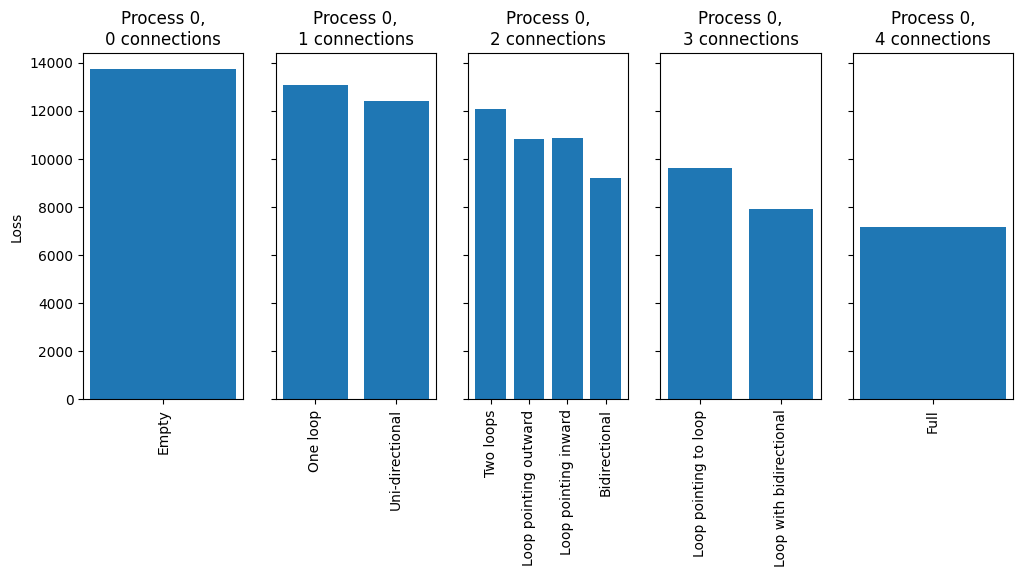

[{0: {'Empty': 13714.994038539508},
  1: {'One loop': 13068.00357574652, 'Uni-directional': 12420.23472404516},
  2: {'Two loops': 12069.091620423787,
   'Loop pointing outward': 10815.947400431987,
   'Loop pointing inward': 10861.540640110497,
   'Bidirectional': 9192.959772866008},
  3: {'Loop pointing to loop': 9605.367408107533,
   'Loop with bidirectional': 7905.886599882538},
  4: {'Full': 7179.95047868078}}]

In [28]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(20, 1e-5), np.full(20, 1e-6), np.full(30, 5e-7))),
           A=np.array([[0.6, 0.8],[-0.8, 0.6]]))

Process dynamics: [[ 0.6  0.8  0. ]
 [-0.8  0.6  0. ]
 [ 0.   0.   0.9]]
Eigenvalues: [0.6+0.8j 0.6-0.8j 0.9+0.j ]
Kalman filter M: [[ 0.36576708  0.48768944  0.        ]
 [-0.48768944  0.36576708  0.        ]
 [ 0.          0.          0.58788979]]
Kalman filter K: [[ 3.90388203e-01 -7.85824477e-18  0.00000000e+00]
 [ 1.17873672e-17  3.90388203e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.46789125e-01]]
Kalman filter loss: 8287.234989271892


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.32454536  0.          0.        ]
 [-0.          0.38394316  0.        ]
 [ 0.          0.          0.43393823]]
NN K: [[ 7.85489942e-01  2.53878598e-01  3.66612645e-03]
 [-2.97467241e-01  7.52666530e-01 -1.82521112e-03]
 [ 1.14158882e-03 -5.38975970e-04  4.60653269e-01]]
Testing Empty, Trial 2
NN M: [[0.35725005 0.         0.        ]
 [0.         0.40226571 0.        ]
 [0.         0.         0.46974705]]
NN K: [[ 0.7655511   0.27783412  0.00082038]
 [-0.31507833  0.73829067  0.00129374]
 [ 0.00140345  0.00078961  0.43730007]]
Testing Empty, Trial 3


  6%|███▎                                                 | 1/16 [14:00<3:30:12, 840.86s/it]

NN M: [[0.38347082 0.         0.        ]
 [0.         0.4132984  0.        ]
 [0.         0.         0.48620737]]
NN K: [[ 7.51710473e-01  2.95894451e-01  5.28792026e-04]
 [-3.22861580e-01  7.30866380e-01 -2.54192220e-03]
 [ 1.95022689e-03  8.15750227e-05  4.26424021e-01]]
Testing Unidirectional, Trial 1
NN M: [[ 0.30992561  0.          0.        ]
 [-0.32096175  0.2957418   0.        ]
 [ 0.          0.          0.42152234]]
NN K: [[ 7.92812286e-01  2.42218618e-01  2.12733379e-03]
 [-4.45373458e-02  5.61855749e-01 -1.99879045e-03]
 [ 1.39789798e-03 -6.35058007e-04  4.69237484e-01]]
Testing Unidirectional, Trial 2
NN M: [[ 0.30204099  0.          0.        ]
 [-0.33977533  0.31670628  0.        ]
 [ 0.          0.          0.40785876]]
NN K: [[ 0.80239525  0.23458541 -0.00337323]
 [-0.0490903   0.53960651  0.0017108 ]
 [ 0.00176725 -0.00262993  0.47667683]]
Testing Unidirectional, Trial 3


 12%|██████▋                                              | 2/16 [28:32<3:20:24, 858.92s/it]

NN M: [[ 0.27986285  0.          0.        ]
 [-0.37651351  0.23705483  0.        ]
 [ 0.          0.          0.3603051 ]]
NN K: [[ 8.15613926e-01  2.11455400e-01  2.40464919e-03]
 [ 3.47113388e-02  5.57816884e-01  1.94685412e-03]
 [ 5.60616541e-04 -1.52326913e-03  5.06418872e-01]]
Testing Source, Trial 1
NN M: [[ 0.32293678  0.          0.        ]
 [-0.2660378   0.40912675  0.        ]
 [ 0.02443084  0.          0.15319823]]
NN K: [[ 0.79018345  0.24979458  0.00632345]
 [-0.16079891  0.54122175  0.00286688]
 [-0.01200044  0.01739162  0.58159346]]
Testing Source, Trial 2
NN M: [[ 0.17046917  0.          0.        ]
 [-0.38493819  0.24204084  0.        ]
 [ 0.02568616  0.          0.28102573]]
NN K: [[ 8.78875452e-01  1.25375088e-01  1.50250223e-03]
 [ 3.41853468e-02  5.45152674e-01  4.88572739e-04]
 [-1.35117418e-02  1.97421546e-02  5.42793190e-01]]
Testing Source, Trial 3


 19%|█████████▉                                           | 3/16 [43:37<3:10:42, 880.17s/it]

NN M: [[ 0.38024004  0.          0.        ]
 [-0.30803109  0.4089365   0.        ]
 [-0.00277413  0.          0.26097437]]
NN K: [[ 0.74817178  0.30058579  0.00258905]
 [-0.14190618  0.50618933 -0.00088323]
 [ 0.00415971 -0.00332431  0.55695178]]
Testing Bidirectional, Trial 1
NN M: [[ 0.28776809  0.24085126  0.        ]
 [-0.30903365  0.15108045  0.        ]
 [ 0.          0.          0.36036823]]
NN K: [[ 6.30402967e-01  7.89467743e-02  5.56259261e-04]
 [ 6.70757474e-02  6.57859536e-01 -6.42105640e-04]
 [ 2.47296776e-03 -2.62382541e-03  5.07223025e-01]]
Testing Bidirectional, Trial 2
NN M: [[ 0.4076779   0.33180784  0.        ]
 [-0.27706939  0.42472939  0.        ]
 [ 0.          0.          0.42574598]]
NN K: [[ 4.85895617e-01  1.29503648e-01  1.32775757e-03]
 [-1.75554736e-01  5.19373011e-01 -1.84533753e-03]
 [ 1.19117562e-03  5.97214486e-05  4.64584039e-01]]
Testing Bidirectional, Trial 3


 25%|█████████████▎                                       | 4/16 [57:07<2:50:27, 852.30s/it]

NN M: [[ 0.33075075  0.32174327  0.        ]
 [-0.11132401  0.47440162  0.        ]
 [ 0.          0.          0.44054363]]
NN K: [[ 0.54264756  0.06625457  0.0023126 ]
 [-0.31009852  0.61543749  0.00090496]
 [ 0.00252281 -0.00116021  0.45245971]]
Testing Linear, Trial 1
NN M: [[ 0.35927537  0.          0.        ]
 [-0.20234528  0.42716654  0.        ]
 [ 0.          0.00390782  0.20596782]]
NN K: [[ 7.63610244e-01  2.84235739e-01 -9.62474691e-05]
 [-2.19462385e-01  5.76089612e-01 -1.03996909e-03]
 [ 1.09016566e-04 -2.30519930e-03  5.75060353e-01]]
Testing Linear, Trial 2
NN M: [[ 0.42047817  0.          0.        ]
 [-0.24289983  0.36624444  0.        ]
 [ 0.          0.03164084  0.26733301]]
NN K: [[ 0.73014824  0.32620621  0.00202196]
 [-0.14462785  0.58264844  0.00193443]
 [-0.02210765 -0.01857891  0.55170782]]
Testing Linear, Trial 3


 31%|███████████████▉                                   | 5/16 [1:09:43<2:29:52, 817.49s/it]

NN M: [[ 0.40253999  0.          0.        ]
 [-0.28228204  0.23427557  0.        ]
 [ 0.          0.03907196  0.22472211]]
NN K: [[ 0.73722214  0.31709225  0.00096068]
 [-0.02064983  0.63048119  0.00193907]
 [-0.03018828 -0.02599058  0.56874648]]
Testing Sink, Trial 1
NN M: [[ 0.17063264  0.          0.        ]
 [-0.36269717  0.33136441 -0.03540672]
 [ 0.          0.          0.32672688]]
NN K: [[ 8.79514288e-01  1.27134141e-01 -4.48985437e-03]
 [-4.81134187e-02  5.09565868e-01  1.95109337e-02]
 [ 1.24496286e-03 -6.01885691e-04  5.23173459e-01]]
Testing Sink, Trial 2
NN M: [[ 0.45692615  0.          0.        ]
 [-0.24498786  0.38186223  0.27753652]
 [ 0.          0.         -0.07384763]]
NN K: [[ 0.70357651  0.36076639  0.00690337]
 [-0.16085721  0.57023303 -0.1273907 ]
 [ 0.00217954 -0.00236898  0.56875609]]
Testing Sink, Trial 3


 38%|███████████████████▏                               | 6/16 [1:22:12<2:12:22, 794.26s/it]

NN M: [[ 0.35101576  0.          0.        ]
 [-0.29127041  0.31570025 -0.11256931]
 [ 0.          0.          0.33383604]]
NN K: [[ 7.73537990e-01  2.79761220e-01 -8.96448315e-03]
 [-8.02776124e-02  5.75785330e-01  6.71889147e-02]
 [ 2.14682831e-03  4.79015886e-05  5.08675842e-01]]
Testing Bidirectional out, Trial 1
NN M: [[-0.00426769  0.35859431  0.        ]
 [-0.32719943  0.35311218  0.        ]
 [-0.02919728  0.          0.24386508]]
NN K: [[ 0.71003348 -0.21439833 -0.00605978]
 [-0.07969419  0.52418432 -0.00342652]
 [ 0.01744519 -0.02224608  0.55613878]]
Testing Bidirectional out, Trial 2
NN M: [[ 0.42304145  0.24748635  0.        ]
 [-0.13686169  0.43376739  0.        ]
 [-0.06763552  0.          0.0698723 ]]
NN K: [[ 0.5414812   0.1899125  -0.01402505]
 [-0.26723553  0.62417184 -0.00362723]
 [ 0.04092653 -0.05240741  0.59116408]]
Testing Bidirectional out, Trial 3


 44%|██████████████████████▎                            | 7/16 [1:34:40<1:56:52, 779.16s/it]

NN M: [[ 0.04155219  0.41384862  0.        ]
 [-0.41783822  0.21549174  0.        ]
 [-0.02074231  0.          0.209922  ]]
NN K: [[ 0.63838026 -0.21040356 -0.00575428]
 [ 0.08013663  0.53471902 -0.0071234 ]
 [ 0.01367997 -0.01783717  0.57094258]]
Testing Transitive triangle, Trial 1
NN M: [[ 0.26779103  0.          0.        ]
 [-0.31328533  0.3870506   0.        ]
 [ 0.06438613  0.00252638  0.04090847]]
NN K: [[ 0.82349995  0.20646451  0.01777273]
 [-0.12159982  0.5134667   0.00373299]
 [-0.03579483  0.04960748  0.60421391]]
Testing Transitive triangle, Trial 2
NN M: [[-0.02552729  0.          0.        ]
 [-0.30924802  0.36273863  0.        ]
 [-0.03459354 -0.0238359   0.13079639]]
NN K: [[ 0.99110372 -0.02855448 -0.00876642]
 [-0.10633395  0.53218706 -0.00842888]
 [ 0.0408388  -0.0137049   0.59448076]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████▌                         | 8/16 [1:47:06<1:42:29, 768.63s/it]

NN M: [[ 0.42952786  0.          0.        ]
 [-0.30963437  0.21584482  0.        ]
 [-0.00812216 -0.0085993   0.13851884]]
NN K: [[ 7.22576237e-01  3.33672605e-01 -2.14205112e-04]
 [ 1.44177325e-02  6.18447299e-01 -3.28365199e-03]
 [ 1.19146937e-02 -3.77871074e-03  5.88662803e-01]]
Testing Bidirectional in, Trial 1
NN M: [[ 0.14633335  0.49443681  0.2760395 ]
 [-0.36962276  0.3330235   0.        ]
 [ 0.          0.         -0.34663001]]
NN K: [[ 0.52129986 -0.17980179 -0.06925627]
 [-0.03240225  0.50907736 -0.0226924 ]
 [ 0.0086431  -0.00545351  0.4778195 ]]
Testing Bidirectional in, Trial 2
NN M: [[ 0.23545156  0.29916228 -0.02090339]
 [-0.28666626  0.52220211  0.        ]
 [ 0.          0.          0.43382727]]
NN K: [[ 0.60963589  0.01060626  0.01739594]
 [-0.24002946  0.44571866  0.00277989]
 [ 0.00121363  0.00200272  0.46297195]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▋                      | 9/16 [1:59:35<1:28:56, 762.41s/it]

NN M: [[ 0.29840035  0.43304414  0.05837171]
 [-0.35500899  0.15470047  0.        ]
 [ 0.          0.          0.26581817]]
NN K: [[ 4.70240466e-01 -2.91423153e-02 -2.89966953e-02]
 [ 9.28094964e-02  6.13240803e-01 -2.03023568e-02]
 [ 1.44026386e-03 -8.07109489e-05  5.41622555e-01]]
Testing Cycle, Trial 1
NN M: [[ 0.39224908  0.          0.09202199]
 [-0.27818952  0.31446968  0.        ]
 [ 0.          0.06753652 -0.21582483]]
NN K: [[ 0.74755209  0.3064444  -0.03081191]
 [-0.0867872   0.588703    0.02491124]
 [-0.0470283  -0.03930325  0.55299191]]
Testing Cycle, Trial 2
NN M: [[ 0.21066912  0.         -0.43446259]
 [-0.42077657  0.08071154  0.        ]
 [ 0.          0.14075823  0.18822651]]
NN K: [[ 0.85101269  0.15647433  0.17991988]
 [ 0.17842373  0.6138241   0.01496339]
 [-0.10685157 -0.09934649  0.46509834]]
Testing Cycle, Trial 3


 62%|███████████████████████████████▎                  | 10/16 [2:12:00<1:15:41, 756.97s/it]

NN M: [[ 0.42565849  0.          0.07778701]
 [-0.29207558  0.32573966  0.        ]
 [ 0.         -0.00156222  0.16501663]]
NN K: [[ 0.72820558  0.3309209  -0.04171965]
 [-0.08515165  0.571013    0.00106932]
 [ 0.00443474  0.00298654  0.5812629 ]]
Testing Bidirectional source, Trial 1
NN M: [[ 3.44591702e-01  2.13132321e-01  0.00000000e+00]
 [-2.67651163e-01  3.44608722e-01  0.00000000e+00]
 [-9.58152006e-03 -4.46257283e-02  1.32583530e-04]]
NN K: [[ 6.15476911e-01  1.43901095e-01 -3.72074261e-04]
 [-1.10437204e-01  5.76201728e-01 -1.29306324e-02]
 [ 4.31853350e-02  1.55305860e-02  5.97721167e-01]]
Testing Bidirectional source, Trial 2
NN M: [[ 0.33300425  0.29291431  0.        ]
 [-0.40645453  0.21911251  0.        ]
 [-0.02043723  0.01937261  0.1290616 ]]
NN K: [[ 0.55984637  0.08588058 -0.0068812 ]
 [ 0.07038863  0.54256684 -0.00146869]
 [ 0.00205325 -0.03035385  0.59158431]]
Testing Bidirectional source, Trial 3


 69%|██████████████████████████████████▍               | 11/16 [2:24:22<1:02:42, 752.56s/it]

NN M: [[ 0.21556443  0.32022942  0.        ]
 [-0.44483414  0.45085297  0.        ]
 [ 0.03570102 -0.02076249 -0.00687178]]
NN K: [[ 0.60054672 -0.01749855  0.01509072]
 [-0.08770398  0.36680213 -0.00280099]
 [-0.00327308  0.03746233  0.59992192]]
Testing Two bidirectionals, Trial 1
NN M: [[ 0.48705201  0.20517576  0.13213794]
 [-0.18322     0.46138226  0.        ]
 [ 0.01537551  0.          0.15373021]]
NN K: [[ 0.53891993  0.26216183 -0.0836125 ]
 [-0.2549291   0.57031051 -0.00921366]
 [-0.01001747  0.01036463  0.57713997]]
Testing Two bidirectionals, Trial 2
NN M: [[ 4.63470597e-01  1.10560570e-01 -6.72260328e-02]
 [-3.06951859e-01  2.91031911e-01  0.00000000e+00]
 [-3.05046886e-04  0.00000000e+00  1.34726335e-01]]
NN K: [[ 6.21909642e-01  3.01364739e-01  4.70791042e-02]
 [-4.86826812e-02  5.73287303e-01 -4.51234190e-04]
 [ 1.92211747e-03  6.53487829e-05  5.94830032e-01]]
Testing Two bidirectionals, Trial 3


 75%|███████████████████████████████████████             | 12/16 [2:36:48<50:02, 750.59s/it]

NN M: [[ 0.37034082  0.32265318 -0.30120787]
 [-0.1759443   0.4465167   0.        ]
 [-0.00332576  0.         -0.49268004]]
NN K: [[ 0.51678616  0.10070673  0.0680951 ]
 [-0.25141926  0.58371681  0.00733476]
 [ 0.00698516 -0.01221381  0.41489493]]
Testing Bidirectional loop, Trial 1
NN M: [[ 0.5194987   0.37216623  0.        ]
 [-0.45558246  0.11511596 -0.04345377]
 [-0.01323036  0.         -0.07522786]]
NN K: [[ 0.38993502  0.18149563  0.00170536]
 [ 0.17514469  0.56700842  0.00136404]
 [ 0.00995332 -0.014476    0.59152542]]
Testing Bidirectional loop, Trial 2
NN M: [[ 0.39109039  0.34120452  0.        ]
 [-0.42462411  0.27771657 -0.3730069 ]
 [-0.20878726  0.         -0.12413896]]
NN K: [[ 0.48540589  0.10416494 -0.0617418 ]
 [ 0.03215146  0.48643216  0.10453076]
 [ 0.12114717 -0.16364582  0.52299533]]
Testing Bidirectional loop, Trial 3


 81%|██████████████████████████████████████████▎         | 13/16 [2:49:15<37:28, 749.58s/it]

NN M: [[ 0.44447165  0.38440891  0.        ]
 [-0.33274433  0.24318489  0.02740017]
 [ 0.01959104  0.          0.20083942]]
NN K: [[ 0.4198466   0.12055745  0.00558581]
 [ 0.00271444  0.58029932 -0.01122241]
 [-0.00934946  0.01565693  0.56936197]]
Testing Bidirectional sink, Trial 1
NN M: [[ 0.36546891  0.          0.        ]
 [-0.33008953  0.21445694  0.09245527]
 [-0.07558855  0.07844424 -0.0903481 ]]
NN K: [[ 0.76503924  0.28311508 -0.00748312]
 [ 0.02567893  0.6065531  -0.01459317]
 [-0.01693149 -0.10328912  0.57946592]]
Testing Bidirectional sink, Trial 2
NN M: [[ 0.19854101  0.          0.        ]
 [-0.3949732   0.25269892 -0.08815426]
 [ 0.03773     0.02849601  0.0122504 ]]
NN K: [[ 0.8587752   0.14824402 -0.00324802]
 [ 0.0320158   0.52868173  0.04086554]
 [-0.03978747  0.00968751  0.58510115]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [3:01:42<24:57, 748.57s/it]

NN M: [[ 0.29115272  0.          0.        ]
 [-0.3865499   0.28071784  0.09507556]
 [-0.0201842  -0.03136744 -0.07538136]]
NN K: [[ 8.11760051e-01  2.24094457e-01  4.30649889e-03]
 [ 1.86861462e-03  5.22560551e-01 -5.01028568e-02]
 [ 4.15684278e-02 -7.30367072e-04  5.83352124e-01]]
Testing Full minus one, Trial 1
NN M: [[ 0.39092693  0.39048821  0.15073064]
 [-0.2820313   0.51806033  0.        ]
 [ 0.03505067 -0.17100774 -0.02771162]]
NN K: [[ 0.43253964  0.06063949 -0.03921002]
 [-0.21819355  0.43921058 -0.03334919]
 [ 0.11368926  0.12375679  0.58467398]]
Testing Full minus one, Trial 2
NN M: [[ 0.46450211  0.41702126  0.0653799 ]
 [-0.24559105  0.47910143  0.        ]
 [ 0.04687688 -0.07002393  0.05139977]]
NN K: [[ 0.38457506  0.12389742 -0.01609062]
 [-0.23817185  0.50768932 -0.01530537]
 [ 0.03024011  0.07712014  0.58995801]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [3:14:06<12:27, 747.19s/it]

NN M: [[ 0.35404409  0.25413457 -0.00486899]
 [-0.1508269   0.35932663  0.        ]
 [ 0.03783835  0.01256443 -0.13746437]]
NN K: [[ 0.57922502  0.13076189  0.01326207]
 [-0.19779284  0.65960685  0.00137585]
 [-0.03262957  0.02037616  0.58445716]]
Testing Full, Trial 1
NN M: [[ 0.22685145  0.20586051  0.07105149]
 [-0.32690849  0.33009133 -0.10288561]
 [-0.05561103 -0.05672999  0.11731974]]
NN K: [[ 0.69661443  0.05209028 -0.053507  ]
 [-0.06194604  0.54051615  0.0446773 ]
 [ 0.08298037 -0.01133183  0.57160388]]
Testing Full, Trial 2
NN M: [[ 0.35028602  0.35685131  0.13713085]
 [-0.28170491  0.21094165  0.04891051]
 [ 0.1210141  -0.12152463 -0.05471993]]
NN K: [[ 0.49764143  0.06663496 -0.01073394]
 [-0.00124498  0.64167272 -0.05315962]
 [ 0.02478295  0.16115047  0.56702202]]
Testing Full, Trial 3


100%|████████████████████████████████████████████████████| 16/16 [3:26:26<00:00, 774.19s/it]

NN M: [[ 0.1584613   0.33320398  0.01880776]
 [-0.42607697  0.09895495  0.07819051]
 [ 0.09672315  0.03957545 -0.11274297]]
NN K: [[ 0.6325595  -0.06908501  0.01854143]
 [ 0.17103044  0.5977619  -0.00841968]
 [-0.08194511  0.05028946  0.57100713]]


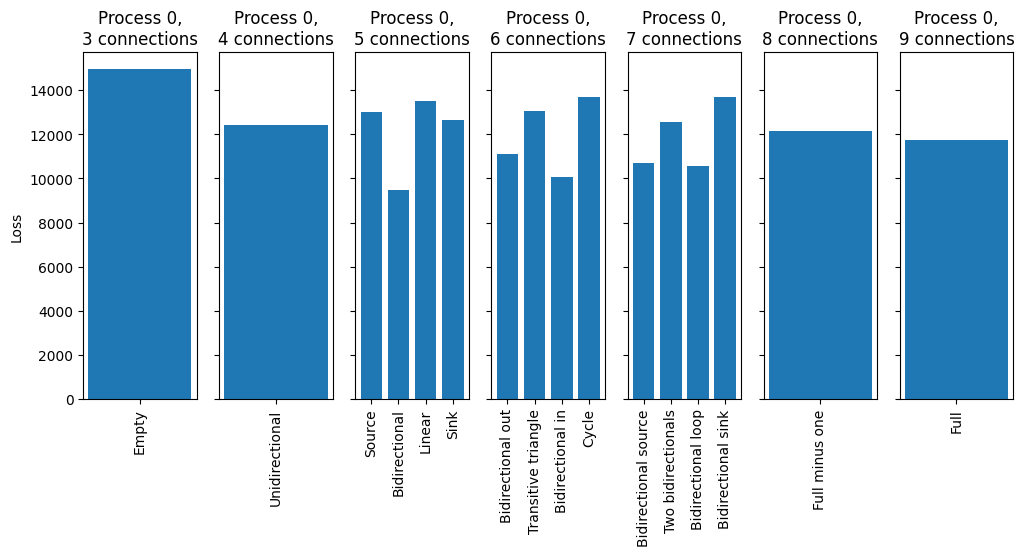

[{3: {'Empty': 14968.617822233158},
  4: {'Unidirectional': 12407.134044067585},
  5: {'Source': 13019.955986357454,
   'Bidirectional': 9482.045774890204,
   'Linear': 13513.418114386814,
   'Sink': 12658.233621732556},
  6: {'Bidirectional out': 11127.881819870216,
   'Transitive triangle': 13044.12219742638,
   'Bidirectional in': 10080.099198610285,
   'Cycle': 13712.086368261364},
  7: {'Bidirectional source': 10690.391401050229,
   'Two bidirectionals': 12553.14024127566,
   'Bidirectional loop': 10552.852688134983,
   'Bidirectional sink': 13715.818204483236},
  8: {'Full minus one': 12171.890314404518},
  9: {'Full': 11763.47889847781}}]

In [32]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(20, 1e-5), np.full(20, 1e-6), np.full(30, 5e-7))),
           A=np.array([[0.6, 0.8, 0],[-0.8, 0.6, 0], [0, 0, 0.9]]))

Process dynamics: [[ 0.8  0.   0. ]
 [ 0.8  0.8  0. ]
 [ 0.8 -0.8  0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.45382871 -0.03070741 -0.04706014]
 [ 0.3951711   0.4224923   0.02522317]
 [ 0.37894418 -0.37555797  0.40078115]]
Kalman filter K: [[ 0.27667951  0.09720943  0.05882517]
 [ 0.09720943  0.44035566 -0.03152897]
 [ 0.05882517 -0.03152897  0.49902357]]
Kalman filter loss: 9363.674019535918


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.00343767 0.         0.        ]
 [0.         0.19717556 0.        ]
 [0.         0.         0.45497214]]
NN K: [[ 0.22628436  0.15661628  0.01794173]
 [ 0.14757819  0.65003506 -0.02112899]
 [ 0.10134331 -0.19202091  0.48500113]]
Testing Empty, Trial 2
NN M: [[-0.14825927  0.          0.        ]
 [ 0.          0.20491396  0.        ]
 [ 0.          0.          0.42666629]]
NN K: [[ 0.18134688  0.16995711  0.01888372]
 [ 0.24085268  0.62171279 -0.02359942]
 [ 0.11012523 -0.26920952  0.50164105]]
Testing Empty, Trial 3


  6%|███▎                                                | 1/16 [25:29<6:22:27, 1529.85s/it]

NN M: [[-0.0743486   0.          0.        ]
 [ 0.          0.16962022  0.        ]
 [ 0.          0.          0.41830352]]
NN K: [[ 0.20397535  0.1708225   0.01948121]
 [ 0.20469282  0.63826081 -0.03048836]
 [ 0.01475167 -0.05887943  0.54872318]]
Testing Unidirectional, Trial 1
NN M: [[-0.00110807  0.          0.        ]
 [ 0.23573551  0.07535067  0.        ]
 [ 0.          0.          0.39891339]]
NN K: [[ 0.18255817  0.21406495  0.03180322]
 [ 0.12778414  0.65135326 -0.04235829]
 [ 0.19281841 -0.32279209  0.52270834]]
Testing Unidirectional, Trial 2
NN M: [[-0.03162802  0.          0.        ]
 [ 0.01393595  0.13999107  0.        ]
 [ 0.          0.          0.41748153]]
NN K: [[ 0.19230251  0.15618029  0.01810998]
 [ 0.26898459  0.6268706  -0.03516499]
 [ 0.08289894 -0.22710333  0.51888228]]
Testing Unidirectional, Trial 3


 12%|██████▌                                             | 2/16 [49:13<5:42:21, 1467.28s/it]

NN M: [[-0.09578427  0.          0.        ]
 [ 0.08450064  0.19744734  0.        ]
 [ 0.          0.          0.36805167]]
NN K: [[ 0.09990733  0.21262897  0.02559803]
 [ 0.1335193   0.64962718 -0.01922236]
 [ 0.0978193  -0.14936228  0.58339118]]
Testing Source, Trial 1
NN M: [[-0.55870528  0.          0.        ]
 [-0.00906744  0.15044242  0.        ]
 [-0.70971741  0.          0.33020439]]
NN K: [[ 0.05933279 -0.05355069 -0.05676349]
 [ 0.1601871   0.65752431 -0.02941903]
 [ 0.1843435  -0.38391065  0.55732327]]
Testing Source, Trial 2
NN M: [[-0.09647568  0.          0.        ]
 [-0.05107952  0.1666681   0.        ]
 [ 0.02343971  0.          0.42066726]]
NN K: [[ 0.13669848  0.14476277  0.013284  ]
 [ 0.12739591  0.69116119 -0.02188029]
 [ 0.12088975 -0.35324685  0.4937466 ]]
Testing Source, Trial 3


 19%|█████████▍                                        | 3/16 [1:25:01<6:25:14, 1778.05s/it]

NN M: [[-0.14334774  0.          0.        ]
 [ 0.06827631  0.15012211  0.        ]
 [-0.00988509  0.          0.39728076]]
NN K: [[ 0.1356977   0.21241657  0.02654091]
 [ 0.15686265  0.67187741 -0.02616722]
 [ 0.144299   -0.30469377  0.52555675]]
Testing Bidirectional, Trial 1
NN M: [[-2.55972983e-04  9.10347330e-03  0.00000000e+00]
 [ 1.04565629e-01  1.76248541e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  2.94830206e-01]]
NN K: [[ 0.21605424  0.16687176  0.02229734]
 [ 0.18810392  0.6245458  -0.02885266]
 [ 0.15198673 -0.2673908   0.63911206]]
Testing Bidirectional, Trial 2
NN M: [[-0.00124729  0.01854907  0.        ]
 [ 0.04428433  0.16480709  0.        ]
 [ 0.          0.          0.40929355]]
NN K: [[ 0.22848191  0.1474958   0.02190842]
 [ 0.17182349  0.6501637  -0.02672863]
 [ 0.06298854 -0.2146661   0.52913692]]
Testing Bidirectional, Trial 3


 25%|████████████▌                                     | 4/16 [1:53:55<5:52:11, 1760.97s/it]

NN M: [[-0.03664186 -0.0049927   0.        ]
 [ 0.15252128  0.14746593  0.        ]
 [ 0.          0.          0.44465913]]
NN K: [[ 0.1358014   0.23175433  0.03044655]
 [ 0.20462638  0.62028093 -0.03546168]
 [ 0.10409063 -0.35315459  0.46762803]]
Testing Linear, Trial 1
NN M: [[-0.0139033   0.          0.        ]
 [ 0.12577168 -0.02310341  0.        ]
 [ 0.         -0.13206865  0.4161609 ]]
NN K: [[ 0.05015584  0.24264059  0.0335629 ]
 [ 0.16416747  0.60263367 -0.07694845]
 [ 0.18296374 -0.26466631  0.48784504]]
Testing Linear, Trial 2
NN M: [[-0.16697855  0.          0.        ]
 [ 0.12768953 -0.11197742  0.        ]
 [ 0.         -0.16575643  0.34005576]]
NN K: [[ 0.1822239   0.20544878  0.02459101]
 [ 0.16123567  0.60515583 -0.09670848]
 [ 0.12103324 -0.176526    0.57409124]]
Testing Linear, Trial 3


 31%|███████████████▋                                  | 5/16 [2:18:08<5:02:26, 1649.70s/it]

NN M: [[ 0.02380295  0.          0.        ]
 [ 0.12240855 -0.09705945  0.        ]
 [ 0.         -0.19490755  0.34926301]]
NN K: [[ 0.2123239   0.1748315   0.02375723]
 [ 0.11638104  0.59308884 -0.09542817]
 [ 0.14750371 -0.217986    0.55312271]]
Testing Sink, Trial 1
NN M: [[-0.07138841  0.          0.        ]
 [ 0.08833788 -0.01700834  0.00336318]
 [ 0.          0.          0.40035181]]
NN K: [[ 0.20072634  0.18301597  0.02289457]
 [ 0.17525317  0.67026039 -0.06375352]
 [ 0.1459582  -0.31874616  0.51680136]]
Testing Sink, Trial 2
NN M: [[0.05521791 0.         0.        ]
 [0.02769955 0.00599717 0.02933284]
 [0.         0.         0.40669528]]
NN K: [[ 0.14653146  0.16742195  0.02091712]
 [ 0.0970218   0.76602194 -0.07073188]
 [ 0.15943502 -0.30488212  0.51441064]]
Testing Sink, Trial 3


 38%|██████████████████▊                               | 6/16 [2:34:53<3:58:27, 1430.70s/it]

NN M: [[0.00580283 0.         0.        ]
 [0.04359252 0.02433509 0.02891765]
 [0.         0.         0.32952232]]
NN K: [[ 0.12968208  0.17680201  0.02011697]
 [ 0.14197079  0.68099235 -0.08393088]
 [ 0.05118422 -0.26254398  0.60196779]]
Testing Bidirectional out, Trial 1
NN M: [[ 0.00261676 -0.06715441  0.        ]
 [ 0.16845065  0.1854289   0.        ]
 [-0.00274503  0.          0.43419857]]
NN K: [[ 0.20984556  0.21386277  0.01611689]
 [ 0.18444282  0.61858664 -0.02653923]
 [ 0.24509709 -0.3093539   0.48782761]]
Testing Bidirectional out, Trial 2
NN M: [[-0.09205083  0.0408438   0.        ]
 [ 0.02894275  0.07645662  0.        ]
 [-0.00867659  0.          0.38553247]]
NN K: [[ 0.22162795  0.12372172  0.01885181]
 [ 0.11744802  0.71092978 -0.03714156]
 [ 0.21412944 -0.36284442  0.52959776]]
Testing Bidirectional out, Trial 3


 44%|█████████████████████▉                            | 7/16 [2:49:29<3:07:23, 1249.29s/it]

NN M: [[-0.42299962  0.10179721  0.        ]
 [-0.01310348  0.16555752  0.        ]
 [ 0.51077284  0.          0.38866028]]
NN K: [[ 0.21504742  0.26246777  0.06773631]
 [ 0.20617209  0.6460075  -0.02994781]
 [ 0.13812742 -0.51397004  0.50103416]]
Testing Transitive triangle, Trial 1
NN M: [[-0.29848438  0.          0.        ]
 [ 0.48318184 -0.16380498  0.        ]
 [ 0.53910153 -0.50898162  0.38275185]]
NN K: [[ 0.25493592  0.36308625  0.07473635]
 [ 0.12075877  0.48118356 -0.14582833]
 [ 0.10067788 -0.31407048  0.42724831]]
Testing Transitive triangle, Trial 2
NN M: [[-0.01385945  0.          0.        ]
 [ 0.05546541  0.06889142  0.        ]
 [ 0.046095   -0.11890711  0.41431014]]
NN K: [[ 0.16227488  0.17393719  0.02285662]
 [ 0.16988032  0.62322195 -0.05207379]
 [ 0.23894049 -0.34203616  0.47761929]]
Testing Transitive triangle, Trial 3


 50%|█████████████████████████                         | 8/16 [3:04:11<2:30:58, 1132.28s/it]

NN M: [[-0.22752506  0.          0.        ]
 [-0.24525645 -0.07056698  0.        ]
 [-0.38368895 -0.53888244  0.29684255]]
NN K: [[ 0.02357825  0.0350019  -0.02024395]
 [ 0.02999891  0.52796365 -0.11877468]
 [ 0.12293965 -0.17547521  0.52925145]]
Testing Bidirectional in, Trial 1
NN M: [[-0.11890193  0.04506808  0.00027795]
 [-0.00417926  0.16131451  0.        ]
 [ 0.          0.          0.24302358]]
NN K: [[ 0.15429602  0.17100416  0.02777385]
 [ 0.11785538  0.67596446 -0.02410543]
 [ 0.09085002 -0.1830527   0.70787559]]
Testing Bidirectional in, Trial 2
NN M: [[-0.11968239 -0.05739172 -0.00027126]
 [ 0.19779498  0.11308071  0.        ]
 [ 0.          0.          0.24675526]]
NN K: [[ 0.16236188  0.24480052  0.02072949]
 [ 0.19430091  0.61356869 -0.04312468]
 [ 0.2394917  -0.29852323  0.68599224]]
Testing Bidirectional in, Trial 3


 56%|████████████████████████████▏                     | 9/16 [3:24:17<2:14:47, 1155.41s/it]

NN M: [[-0.16289475  0.08302174  0.00521276]
 [ 0.08975053  0.18402159  0.        ]
 [ 0.          0.          0.34140297]]
NN K: [[ 0.15336383  0.18245834  0.03078074]
 [ 0.21422845  0.61974875 -0.02792942]
 [ 0.08149927 -0.26159487  0.59204384]]
Testing Cycle, Trial 1
NN M: [[-0.19229779  0.         -0.06459333]
 [-0.0767963  -0.19649837  0.        ]
 [ 0.         -0.49212677  0.42203335]]
NN K: [[ 0.18526523  0.20190065  0.09047885]
 [ 0.09978728  0.52433669 -0.14230108]
 [ 0.24341207 -0.29408105  0.3974907 ]]
Testing Cycle, Trial 2
NN M: [[-0.21743315  0.         -0.00552041]
 [-0.0349018   0.05333812  0.        ]
 [ 0.         -0.09610434  0.38457321]]
NN K: [[ 0.17680915  0.1450586   0.01752588]
 [ 0.09565486  0.65877758 -0.05474439]
 [ 0.1557837  -0.23898978  0.53406516]]
Testing Cycle, Trial 3


 62%|██████████████████████████████▋                  | 10/16 [3:48:16<2:04:17, 1242.90s/it]

NN M: [[-0.15930734  0.         -0.05327505]
 [-0.14768998 -0.04929179  0.        ]
 [ 0.         -0.21406411  0.31158177]]
NN K: [[ 0.1428647   0.11564399  0.06096868]
 [ 0.08669618  0.61068664 -0.08822282]
 [ 0.10413174 -0.17057061  0.59398776]]
Testing Bidirectional source, Trial 1
NN M: [[-0.16325098  0.1813561   0.        ]
 [ 0.27803293 -0.23614817  0.        ]
 [ 0.23622087 -0.40445421  0.34627539]]
NN K: [[ 0.19438308  0.2541906   0.07819785]
 [ 0.13333173  0.50671682 -0.14518313]
 [ 0.14897391 -0.26644198  0.50276424]]
Testing Bidirectional source, Trial 2
NN M: [[-0.16136845  0.10889613  0.        ]
 [ 0.12291978  0.16170394  0.        ]
 [ 0.05072007 -0.05147735  0.39142172]]
NN K: [[ 0.07863467  0.17788935  0.04123607]
 [ 0.19309224  0.63541515 -0.02984327]
 [ 0.20153389 -0.31217487  0.52110379]]
Testing Bidirectional source, Trial 3


 69%|█████████████████████████████████▋               | 11/16 [4:10:18<1:45:34, 1267.00s/it]

NN M: [[ 0.02456444 -0.12834943  0.        ]
 [ 0.05934046 -0.18575832  0.        ]
 [-0.01063249 -0.3365558   0.3506765 ]]
NN K: [[ 0.22686644  0.17161836 -0.00571701]
 [ 0.03541645  0.57974273 -0.12268068]
 [ 0.14845311 -0.16740607  0.52938856]]
Testing Two bidirectionals, Trial 1
NN M: [[-0.45655245  0.07662599 -0.11750915]
 [ 0.10385013  0.09898542  0.        ]
 [ 0.3124381   0.          0.32888645]]
NN K: [[ 0.2736523   0.28383874  0.17414708]
 [ 0.15331058  0.65840971 -0.04153228]
 [ 0.0554053  -0.35805254  0.59260874]]
Testing Two bidirectionals, Trial 2
NN M: [[-0.2685685  -0.08281166 -0.0150462 ]
 [ 0.13629358  0.08378363  0.        ]
 [ 0.03317776  0.          0.29807453]]
NN K: [[ 0.18392416  0.18317111  0.01627526]
 [ 0.1225753   0.65346379 -0.04426939]
 [ 0.12238686 -0.27571199  0.63578865]]
Testing Two bidirectionals, Trial 3


 75%|████████████████████████████████████▊            | 12/16 [4:23:14<1:14:30, 1117.61s/it]

NN M: [[-0.2778335  -0.0370234  -0.09009554]
 [-0.07339105  0.26078188  0.        ]
 [ 0.10226429  0.          0.37146738]]
NN K: [[ 0.15428274  0.22854237  0.11063777]
 [ 0.15572247  0.63254187 -0.01255783]
 [ 0.19230172 -0.33152912  0.54829282]]
Testing Bidirectional loop, Trial 1
NN M: [[-0.4144874   0.1020108   0.        ]
 [ 0.24207657  0.02926762  0.10643379]
 [-0.43304484  0.          0.42467001]]
NN K: [[ 0.09889483  0.06629512  0.00283666]
 [ 0.14413087  0.69312224 -0.15335164]
 [ 0.20973642 -0.35180255  0.48157213]]
Testing Bidirectional loop, Trial 2
NN M: [[-0.08703665 -0.08954551  0.        ]
 [-0.01930012  0.02036168  0.03911306]
 [ 0.05625917  0.          0.39296402]]
NN K: [[ 0.22844659  0.17516568  0.00094847]
 [ 0.13638123  0.68001484 -0.09404325]
 [ 0.12040129 -0.36024315  0.52195459]]
Testing Bidirectional loop, Trial 3


 81%|█████████████████████████████████████████▍         | 13/16 [4:36:05<50:38, 1012.70s/it]

NN M: [[-0.09170909  0.1789671   0.        ]
 [ 0.0980894   0.01250804  0.00868049]
 [ 0.02788353  0.          0.43157639]]
NN K: [[ 0.2139217   0.11226094  0.04687097]
 [ 0.14959388  0.709582   -0.05738816]
 [ 0.10040159 -0.31997981  0.48902576]]
Testing Bidirectional sink, Trial 1
NN M: [[-0.11579403  0.          0.        ]
 [ 0.40321181 -0.20461686  0.20081173]
 [ 0.32649571 -0.47652225  0.36935538]]
NN K: [[ 0.23001897  0.34555148  0.05358312]
 [ 0.02468176  0.38384665 -0.36539206]
 [ 0.17330492 -0.28527842  0.46710808]]
Testing Bidirectional sink, Trial 2
NN M: [[-0.12039638  0.          0.        ]
 [-0.07963001 -0.35269671  0.15178298]
 [-0.03192091 -0.33244427  0.33421357]]
NN K: [[ 0.22788161  0.09759526  0.00466254]
 [ 0.089237    0.50656179 -0.32777151]
 [ 0.21766914 -0.20329478  0.54120354]]
Testing Bidirectional sink, Trial 3


 88%|█████████████████████████████████████████████▌      | 14/16 [4:49:04<31:24, 942.01s/it]

NN M: [[-0.14676471  0.          0.        ]
 [-0.00712857  0.02674612 -0.12516127]
 [ 0.03878709  0.10256073  0.3742207 ]]
NN K: [[ 0.21657905  0.17403642  0.01933299]
 [ 0.23654133  0.68449773  0.07779641]
 [ 0.07619771 -0.36042933  0.56085029]]
Testing Full minus one, Trial 1
NN M: [[-0.22952417 -0.06124553 -0.06178711]
 [ 0.18808742 -0.18119958  0.        ]
 [ 0.14775021 -0.33143422  0.36053962]]
NN K: [[ 0.17932843  0.25461596  0.0862366 ]
 [ 0.1363137   0.53756396 -0.12626608]
 [ 0.16397171 -0.27634463  0.50056963]]
Testing Full minus one, Trial 2
NN M: [[-0.24239532  0.06724104 -0.06239309]
 [ 0.21665612 -0.17206212  0.        ]
 [ 0.20885004 -0.41972082  0.29972901]]
NN K: [[ 0.19807792  0.27921419  0.11967093]
 [ 0.14859098  0.51528943 -0.12838659]
 [ 0.16267186 -0.19763321  0.56350562]]
Testing Full minus one, Trial 3


 94%|████████████████████████████████████████████████▊   | 15/16 [5:02:10<14:55, 895.02s/it]

NN M: [[-0.18682436  0.00048242  0.00939882]
 [ 0.0834371  -0.12434861  0.        ]
 [ 0.0445865  -0.39903858  0.29825849]]
NN K: [[ 0.21699855  0.17247938  0.00859506]
 [ 0.14468567  0.58594349 -0.10564717]
 [ 0.16211895 -0.16282985  0.57100988]]
Testing Full, Trial 1
NN M: [[-0.27537224  0.2195487  -0.03898564]
 [ 0.11690281 -0.07192644  0.07654672]
 [ 0.16344069 -0.14888402  0.38767391]]
NN K: [[ 0.21990958  0.18544526  0.1070576 ]
 [ 0.09608455  0.70736868 -0.14689534]
 [ 0.1109007  -0.271379    0.51266324]]
Testing Full, Trial 2
NN M: [[-0.33808632 -0.10990294  0.17500084]
 [-0.09916542 -0.06712877  0.11422377]
 [-0.51075013 -0.29965817  0.27097447]]
NN K: [[ 0.0698314  -0.00647629 -0.2329433 ]
 [ 0.09488527  0.60911163 -0.2108225 ]
 [ 0.13308561 -0.09568845  0.62213367]]
Testing Full, Trial 3


100%|███████████████████████████████████████████████████| 16/16 [5:15:16<00:00, 1182.26s/it]

NN M: [[-0.28538824  0.06125594 -0.0042753 ]
 [ 0.05694217 -0.24580444  0.19679169]
 [ 0.04488914 -0.32698189  0.36764627]]
NN K: [[ 0.21722492  0.13695731  0.02558033]
 [ 0.12221118  0.52867733 -0.34612595]
 [ 0.24111514 -0.23389004  0.49910769]]


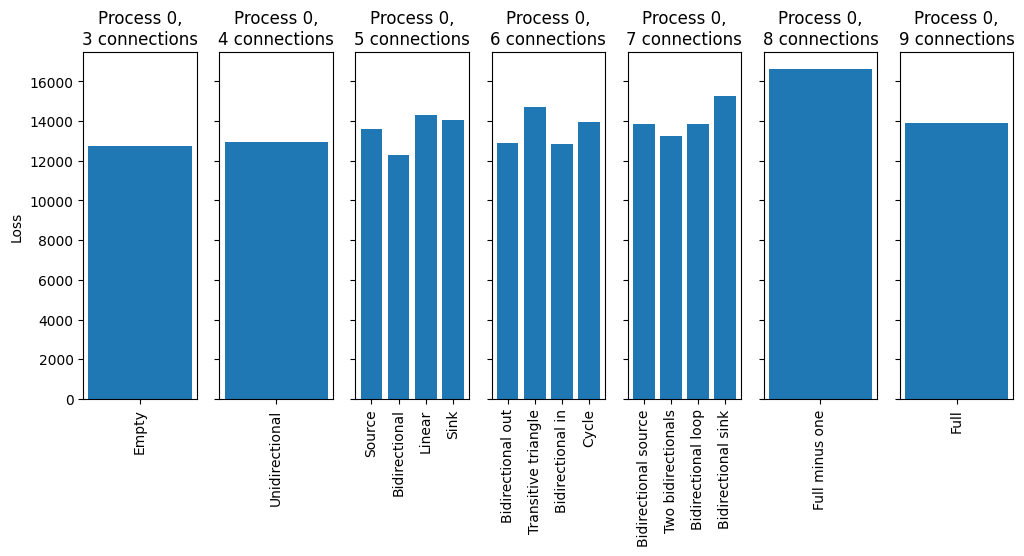

[{3: {'Empty': 12738.646620107027},
  4: {'Unidirectional': 12939.817419939278},
  5: {'Source': 13611.731668966187,
   'Bidirectional': 12306.717485952186,
   'Linear': 14293.676779324058,
   'Sink': 14041.724571075225},
  6: {'Bidirectional out': 12873.903499861706,
   'Transitive triangle': 14708.95257967538,
   'Bidirectional in': 12818.443571297958,
   'Cycle': 13938.461336465347},
  7: {'Bidirectional source': 13830.452107363497,
   'Two bidirectionals': 13244.152409247265,
   'Bidirectional loop': 13826.529125209963,
   'Bidirectional sink': 15279.98377580454},
  8: {'Full minus one': 16625.880359157032},
  9: {'Full': 13918.851288389591}}]

In [48]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(20, 3e-7), np.full(20, 1e-7))),
           A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))

A = [[ 0.8  0.   0. ]
 [ 0.8  0.8  0. ]
 [ 0.8 -0.8  0.8]]
Eigenvalues =  [0.8 0.8 0.8]


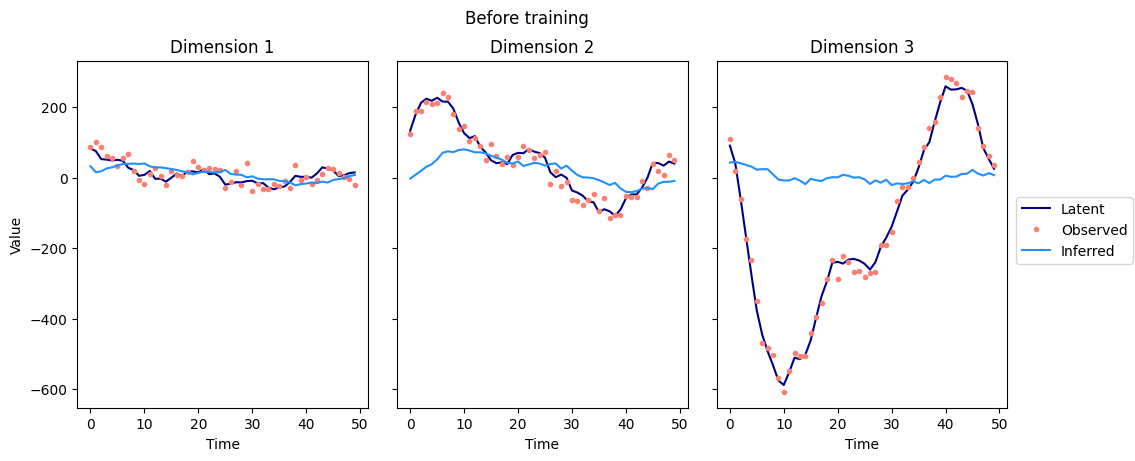

Loss 1374657.8595526922
M = [[ 0.11374287  0.09109814  0.10754248]
 [-0.06692941 -0.00042179  0.12537195]
 [-0.07708122  0.07641694  0.05779387]]
K = [[-0.10240507  0.09511524 -0.02165391]
 [ 0.15371262 -0.04395568 -0.15240157]
 [ 0.12820027  0.16180615  0.05291291]]


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.44it/s]


Mean loss 946336.1460686267


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.42it/s]


Mean loss 710216.2233711921


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.40it/s]


Mean loss 364107.40130256175


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.69it/s]


Mean loss 126719.53825573814


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.48it/s]


Mean loss 40767.97026455663


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.35it/s]


Mean loss 63049.175295404995


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.90it/s]


Mean loss 89963.82495237343


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.16it/s]


Mean loss 340545.62764632504


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.64it/s]


Mean loss 107795.45392852661


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.93it/s]


Mean loss 227442.85313842742


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.66it/s]


Mean loss 129838.79005078235


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


Mean loss 131321.89655787178


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.59it/s]


Mean loss 127285.81729637648


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


Mean loss 92918.81748489132


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.56it/s]


Mean loss 133040.79493346042


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.88it/s]


Mean loss 72246.3742280066


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.90it/s]


Mean loss 110206.92467361913


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.85it/s]


Mean loss 38273.28447694148


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.78it/s]


Mean loss 97420.12387030055


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.90it/s]


Mean loss 40146.90334693657


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.78it/s]


Mean loss 112427.73646704017


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.61it/s]


Mean loss 39240.111770735006


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.43it/s]


Mean loss 104144.95259009724


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.68it/s]


Mean loss 40433.88645844592


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.11it/s]


Mean loss 107469.24336476254


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.90it/s]


Mean loss 40127.565951328805


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.57it/s]


Mean loss 100933.48635973607


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.13it/s]


Mean loss 45753.19639973425


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.23it/s]


Mean loss 112842.7386033623


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.50it/s]


Mean loss 45332.95963353368


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.29it/s]


Mean loss 110069.58298450199


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.96it/s]


Mean loss 33098.307041776054


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.70it/s]


Mean loss 63088.423768043736


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  5.98it/s]


Mean loss 39416.1792418177


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.04it/s]


Mean loss 70925.80097467426


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.18it/s]


Mean loss 41129.918834127675


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.13it/s]


Mean loss 69116.06214737865


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.47it/s]


Mean loss 36533.35439685827


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.74it/s]


Mean loss 65455.10328869467


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.33it/s]


Mean loss 39091.00052745869


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


Mean loss 62801.78898718736


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.12it/s]


Mean loss 39160.32360187952


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.71it/s]


Mean loss 60757.527619672204


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.75it/s]


Mean loss 36241.27193009837


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.73it/s]


Mean loss 61259.559741184894


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.54it/s]


Mean loss 32339.920290499984


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.23it/s]


Mean loss 59188.70851941955


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.27it/s]


Mean loss 35821.85448107323


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.36it/s]


Mean loss 76435.39889377887


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.24it/s]


Mean loss 37954.52970947306


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.61it/s]


Mean loss 64160.005728505996


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.81it/s]


Mean loss 23786.38428473938


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.33it/s]


Mean loss 19673.14091293654


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.68it/s]


Mean loss 20809.875807481683


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.53it/s]


Mean loss 20896.50525019186


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.14it/s]


Mean loss 20762.775187248724


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.39it/s]


Mean loss 21790.28572065332


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.50it/s]


Mean loss 19272.96920356487


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.44it/s]


Mean loss 20086.115183622227


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.25it/s]


Mean loss 19927.2192319182


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.59it/s]


Mean loss 19723.77893226021


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.65it/s]


Mean loss 20616.272964500393


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.18it/s]


Mean loss 18971.89399748347


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.37it/s]


Mean loss 19651.59130069825


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.73it/s]


Mean loss 18331.21836411623


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.68it/s]


Mean loss 19778.383387131536


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.67it/s]


Mean loss 19079.5756435865


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.80it/s]


Mean loss 21453.368780174977


100%|███████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.13it/s]


Mean loss 18841.497553198707


100%|███████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.17it/s]


Mean loss 21196.868897097087


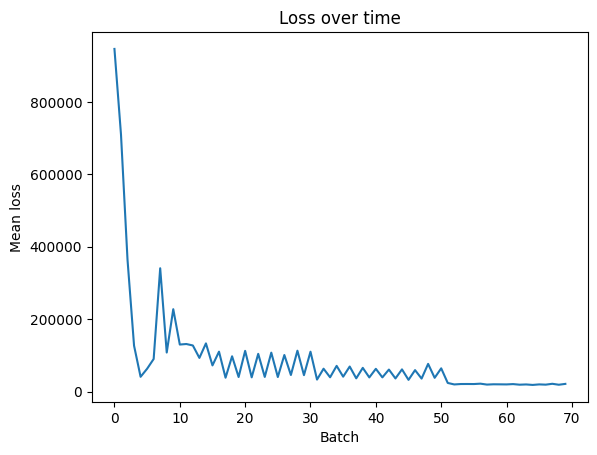

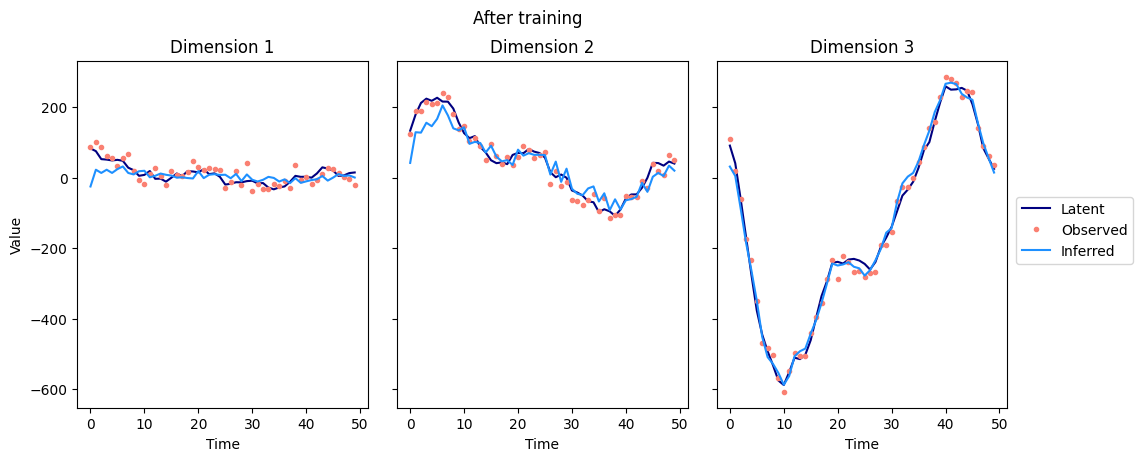

Loss 22139.968568825094
M = [[-0.25296821 -0.07897508  0.15581707]
 [-0.19397469 -0.12130098  0.2223186 ]
 [-0.27228491 -0.30932221  0.39788251]]
K = [[ 0.05341603  0.06421175 -0.18459244]
 [ 0.2080381   0.56670874 -0.33970406]
 [ 0.19779535 -0.16377021  0.4821282 ]]


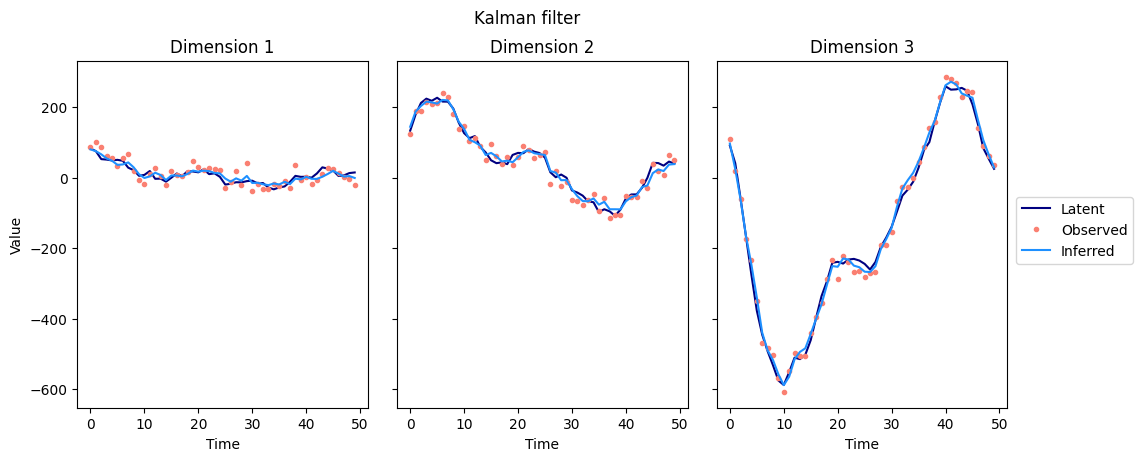

Loss 9752.618550274783
M = [[ 0.45382871 -0.03070741 -0.04706014]
 [ 0.3951711   0.4224923   0.02522317]
 [ 0.37894418 -0.37555797  0.40078115]]
K = [[ 0.27667951  0.09720943  0.05882517]
 [ 0.09720943  0.44035566 -0.03152897]
 [ 0.05882517 -0.03152897  0.49902357]]


In [47]:
proc = mk_nd_proc(rng, 3,
                  A=np.array([[0.8, 0, 0], [0.8, 0.8, 0], [0.8, -0.8, 0.8]]))
compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-6), np.full(15, 5e-7), np.full(20, 3e-7), np.full(20, 1e-7))))